# Telecom Churn Case Study

The main goal of the case study is to build ML models to predict churn. The predictive model that we are going to build will the following purposes:<br>
<br>
It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.<br>
<br>
It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.<br>
<br>
Even though overall accuracy will be our primary evaluation metric, we should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.<br>
<br>
We are supposed to recommend strategies to manage customer churn based on our observations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
################################################
# For printing in the output screen in bold.   #
################################################
class ColorForPrint:
    BOLD = '\033[1m'
    END = '\033[0m'

In [3]:
# Loading the dataset
Telecom_DF = pd.read_csv('train (1).csv')
Telecom_DF.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [4]:
#################################################################################################################
# Common class for some data operations that are to be carried out. DataFrame object is passed in this class.   #
#################################################################################################################
class DataUnderstanding:
    def __init__(self, Telecom_DF):
        self.Telecom_DF = Telecom_DF
        self.RemoveUnwantedRowsCols = self.RemoveUnwantedRowsCols(self)
    #############################################
    # Alternative for df.info and df.describe   #
    #############################################
    def dataDescription(self):
        print("Total number values are", self.Telecom_DF.size)
        print("Telecom Data set has", self.Telecom_DF.shape[0], "rows and", self.Telecom_DF.shape[1], "columns")
        print("Number of dimensions are", self.Telecom_DF.ndim) # as it is a DataFrame
        print()
        DataTypes = self.Telecom_DF.dtypes.value_counts()
        print("There are", len(DataTypes), "datatypes in the data set",)
        print(DataTypes)
        print()
        # Mean takes time as this query took time even without the function
        print(ColorForPrint.BOLD,"Mean of Dataset ", ColorForPrint.END)
        #print("Please wait.... ") 
        print(self.Telecom_DF.mean().sort_values(ascending = False).head(20))
        print()
        print(ColorForPrint.BOLD,"Median of Dataset ", ColorForPrint.END)
        print(self.Telecom_DF.median().sort_values(ascending = False).head(20))
        print()
        print(ColorForPrint.BOLD,"Standard deviation of Dataset ", ColorForPrint.END)
        print(self.Telecom_DF.std().sort_values(ascending = False).head(20))
        print()
        print(ColorForPrint.BOLD,"Minumum Value of Dataset ", ColorForPrint.END)
        print(self.Telecom_DF.min().head(20))
        print()
        print(ColorForPrint.BOLD,"Maximum Value of Dataset ", ColorForPrint.END)
        print(self.Telecom_DF.max().head(20))
        print()
        print(ColorForPrint.BOLD,"25% of Dataset ", ColorForPrint.END)
        print(self.Telecom_DF.quantile(0.25).sort_values(ascending = False).head(20))
        print()
        print(ColorForPrint.BOLD, "50% of Dataset ", ColorForPrint.END)
        print(self.Telecom_DF.quantile(0.50).sort_values(ascending = False).head(20))
        print()
        print(ColorForPrint.BOLD, "75% of Dataset ", ColorForPrint.END)
        print(self.Telecom_DF.quantile(0.75).sort_values(ascending = False).head(20))
        print()
        print(ColorForPrint.BOLD, "Total number of Null Values ", ColorForPrint.END)
        NullDF = (Telecom_DF.isnull().sum().sort_values(ascending = False)).to_frame()
        NullDF.columns = ['NullValues']
        NullValuesCount = NullDF[NullDF == NullDF['NullValues'][0]].count()[0]
        if NullValuesCount > 0:
            print("There are columns with all values as null values. So we have to remove it.")
        else:
            print("There are no columns with all values as null values.")
        print()    
    ##########################################################
    # Class for analyzing the rows and columns in a dataset  #
    ##########################################################
    class RemoveUnwantedRowsCols():
        def __init__(self, DataUnderstanding):
            # To access the dataframe defined in the outer class we are in need of this
            self.dataUnderObj = DataUnderstanding
            
        ##########################################################
        # Remove columns only if all the values are NaN          #
        ##########################################################
        def checkForUnwantedColumns(self, ColumnValues):
            unwantedCols = []
            for column in ColumnValues:
                # Check if all the column values are null or all column values are the same (can be anything) then only remove it.  
                if (Telecom_DF[column].isnull().all()) or (Telecom_DF[column][0] == Telecom_DF[column].all()):
                    unwantedCols.append(column)
                else: 
                    continue
            print("There are", len(unwantedCols) ,"unwanted columns in the dataset")
            return unwantedCols
        
        ######################################################################################################
        # 0's would add no meaning to the dataset so we remove it. Model may learn 0's so we eliminate it.   #
        ######################################################################################################
        def checkForZeroValues(self):
            columnList = []
            countList = []
            ZeroValueCountDF = pd.DataFrame(columns = ['Column Name', 'Count'])
            for column in Telecom_DF.columns:
                flag = False
                count  = 0
                for value in Telecom_DF[column]:
                    # Since most of the values in the dataset are float we check with 0.0
                    if str(value) == "0.0":
                        flag = True
                        count = count + 1
                if flag == True:
                    ZeroValueCountDF = ZeroValueCountDF.append({'Column Name':column ,'Count':count} ,ignore_index=True)
            return ZeroValueCountDF

        #######################################################################################################################
        # Performs null value column analysis, given a threshold of default 10 as that the number of high value for the rows. # 
        # So we can omit the columns .                                                                                        #
        #######################################################################################################################
        def nullValueColumnAnalysis(self, threshold = 10):
            NullCountRows = self.dataUnderObj.Telecom_DF.isnull().sum().to_frame('Null Count')
            NullCountRows = NullCountRows[NullCountRows['Null Count'] > threshold]
            if len(NullCountRows > 0):
                print("There are ",len(NullCountRows)," null column values with more than the given threshold.So we should be removing it.")
                return NullCountRows
            else:
                print("There are no column null values greater than a threshold of", threshold ,"in the dataset")
                
        #############################################################################################################################
        # Checks how many null values are present in a row. If remove rows values is true, it will return the rows to be removed.   #
        #############################################################################################################################
        def nullValueRowAnalysis(self, RemoveRows = False):
            countValueDF = pd.DataFrame([], columns = ["NullRowCount"])
            countValueList = []
            Telecom_DFRangeCount = range(len(self.dataUnderObj.Telecom_DF)-1)
            for i in Telecom_DFRangeCount:
                countValue = self.dataUnderObj.Telecom_DF.iloc[i].isnull().sum()
                countValueDF.at[i,"NullRowCount"]= countValue
            if (countValue > 0) and (RemoveRows == True):
                return list(countValueDF[countValueDF["NullRowCount"] > 0].index)
            
            CountValueRangeCount = range(len(countValueDF.value_counts()) -1)
            # Now we will plot the count
            for i in CountValueRangeCount:
                Df = countValueDF[countValueDF['NullRowCount'] > i]
                countValueList.append(len(Df))
            # Gets the unique row value of the count. 
            print("unique row values are", set(countValueList))
            fig = plt.figure(figsize = (10, 5))
            # creating the bar plot
            x = range(len(countValueDF.value_counts()) -1)
            plt.bar(x, countValueList, color ='maroon',
                    width = 0.4)
            plt.xlabel('Null values')
            plt.ylabel('number of Rows')
            plt.show()
            
    ###############################################################
    # Detect continuous and categorical variables in the dataset. #
    ###############################################################
    def detectContinuousCategorical(self):
        continuous_variables = []
        categorical_variables = []
        for column in self.Telecom_DF.columns:
            Category = len(self.Telecom_DF[column].value_counts())
            print(column,":",Category)
            if Category > 26:
                continuous_variables.append(column)
            else:
                categorical_variables.append(column)
        return continuous_variables, categorical_variables
    
    ###############################################################
    # Understand the column distribution in the dataset.          #
    ###############################################################
    def understandDistribution(self, column, label):
        plt.figure(figsize=(15,8))
        plt.subplot(1,2,1)
        plt.title(label+'Distribution Plot')
        sb.distplot(column)

        plt.subplot(1,2,2)
        plt.title(label+'Spread')
        sb.boxplot(y=column)
        plt.show()
    
    ###############################################################
    # Perform column analysis on numerical data.                  #
    ###############################################################
    def numericalColumnsAnalysis(self, continuous, segmented):
        non_integer_types = []
        if segmented == False:
            for s in continuous:
                # Some variables would misbehave hence we are using Try Catch. 
                try:
                    self.Telecom_DF.boxplot( column=s)
                    plt.ylabel(s)
                    plt.show()
                except:
                    print(s, "is not of type integer")
                    non_integer_types.append(s)
                    continue
            return non_integer_types
        # Check for segmented analysis in numerical columns
        if segmented == True:
            for s in continuous:
                # Some variables would misbehave hence we are using Try Catch. 
                try:
                    self.Telecom_DF.boxplot(column= s, by= "pricesegment")
                    plt.ylabel(s)
                    plt.xlabel(s)
                    plt.show()
                except:
                    print(s, "is not of type integer")
                    continue
                    
    ###############################################################
    # Perform categorical analysis on numerical data.             #
    ###############################################################        
    def categoricalColumnsAnalysis(self, categorical_values, segmented):
        if segmented == False:
            for i in categorical_values:
                sb.countplot(x=i, data=Telecom_DF)
                plt.xlabel(i)
                plt.show()
        # Check for segmented analysis in categorical columns. 
        if segmented == True:
            for i in categorical_values:
                sb.countplot(x=i, hue="churn_probability", data=Telecom_DF)
                plt.xticks(rotation=90)
                plt.xlabel(i)
                plt.show()

In [5]:
# We are using the dataframe for the whole class. 
obj = DataUnderstanding(Telecom_DF)

In [6]:
# The below gives a good overview of the data. 
obj.dataDescription()

Total number values are 12039828
Telecom Data set has 69999 rows and 172 columns
Number of dimensions are 2

There are 3 datatypes in the data set
float64    135
int64       28
object       9
dtype: int64

 Mean of Dataset  
id                    34999.000000
aon                    1220.639709
total_rech_amt_6        328.139788
total_rech_amt_8        323.846355
total_rech_amt_7        322.376363
total_og_mou_7          310.572674
total_og_mou_6          306.451436
total_og_mou_8          304.513065
arpu_6                  283.134365
arpu_8                  278.858826
arpu_7                  278.185912
total_ic_mou_7          201.878029
av_rech_amt_data_7      201.455940
total_ic_mou_6          199.710640
offnet_mou_6            198.874771
total_ic_mou_8          198.486034
offnet_mou_7            197.153383
av_rech_amt_data_8      196.815792
offnet_mou_8            196.543577
av_rech_amt_data_6      192.831096
dtype: float64

 Median of Dataset  
id                    34999.000
aon   

In [7]:
# This will display the list of all unwanted columns. 
UnwantedColumns = obj.RemoveUnwantedRowsCols.checkForUnwantedColumns(list(Telecom_DF.columns))
UnwantedColumns

There are 69 unwanted columns in the dataset


['id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_7',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_8',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8',
 'std_ic_t2t_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'std_ic_t2f_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'spl_ic_mou_6',
 'spl_ic_mou_7',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'ic_others_8',
 'last_day_rch_amt_8',
 'vol_2g_mb_6',
 'vol_2g_mb_7',
 'vol_2g_mb_8',
 'vol_3g_mb_6',
 'vol_3g_mb_7',
 'vol_3g_mb_8',
 'mo

In [8]:
# Now we have to check the number of null values column wise. 
UnwantedColumnsList = obj.RemoveUnwantedRowsCols.nullValueColumnAnalysis()
UnwantedColumnsList[UnwantedColumnsList["Null Count"]<100]

There are  125  null column values with more than the given threshold.So we should be removing it.


,Null Count


There seems to be a lot of null values in the dataframe. Let us check if the ratio to decide whether we are going to remove rows for some columns or not.


In [9]:
# Threshold of upto 10000 records are missing for 95 columns. So we will remove the rows for them. 
# Since removal of 10000 rows is lesser compared to removing the whole columns which would lose the major part of the dataset, we use this method.  
UnwantedColumnsList[UnwantedColumnsList["Null Count"]<10000]

,Null Count
loc_og_t2o_mou,702
std_og_t2o_mou,702
loc_ic_t2o_mou,702
last_date_of_month_7,399
last_date_of_month_8,733
...,...
ic_others_7,2687
ic_others_8,3703
date_of_last_rech_6,1101
date_of_last_rech_7,1234


In [10]:
# Now let us check for a higher threshold of records having null values greater than 30000
UnwantedColumnsList[UnwantedColumnsList["Null Count"]>30000]

,Null Count
date_of_last_rech_data_6,52431
date_of_last_rech_data_7,52134
date_of_last_rech_data_8,51582
total_rech_data_6,52431
total_rech_data_7,52134
total_rech_data_8,51582
max_rech_data_6,52431
max_rech_data_7,52134
max_rech_data_8,51582
count_rech_2g_6,52431


Since most of all the records are greater than 50000 which is a huge number of null values for the columns, we remove the whole column. 

In [11]:
unwantedColumns = list(UnwantedColumnsList[UnwantedColumnsList["Null Count"]>30000].index)

In [12]:
ZeroValueCountDF = obj.RemoveUnwantedRowsCols.checkForZeroValues()
# Since there may be 0 as values hence we have to remove only the ones that have most of the values as 0.
ZeroValueCountDF

,Column Name,Count
0,loc_og_t2o_mou,69297
1,std_og_t2o_mou,69297
2,loc_ic_t2o_mou,69297
3,arpu_6,2603
4,arpu_7,2666
...,...,...
121,fb_user_7,1616
122,fb_user_8,2020
123,aug_vbc_3g,58348
124,jul_vbc_3g,58747


In [13]:
ZeroValueCountDF[ZeroValueCountDF['Count'] > 60000]

,Column Name,Count
0,loc_og_t2o_mou,69297
1,std_og_t2o_mou,69297
2,loc_ic_t2o_mou,69297
42,std_og_t2c_mou_6,67231
43,std_og_t2c_mou_7,67312
44,std_og_t2c_mou_8,66296
48,isd_og_mou_6,63897
49,isd_og_mou_7,64180
50,isd_og_mou_8,63384
55,og_others_7,67072


After checking that the above columns there are more values with 0.0, we can proceed removing the columns. 

In [14]:
Telecom_DF = Telecom_DF.drop(unwantedColumns, axis = 1)

In [15]:
# Id is not necessary hence we drop it. 
Telecom_DF = Telecom_DF.drop("id", axis = 1)

In [16]:
Telecom_DF = Telecom_DF.drop(list(ZeroValueCountDF[ZeroValueCountDF['Count'] > 60000]['Column Name']), axis = 1)

In [17]:
Telecom_DF.shape

(69999, 127)

In [18]:
obj = DataUnderstanding(Telecom_DF)

In [19]:
# Now we have to check the number of null values column wise. 
UnwantedColumnsList = obj.RemoveUnwantedRowsCols.nullValueColumnAnalysis()
max(UnwantedColumnsList['Null Count'])

There are  81  null column values with more than the given threshold.So we should be removing it.


3703

In [20]:
UnwantedColumnsList[UnwantedColumnsList['Null Count'] == max(UnwantedColumnsList['Null Count'])]

,Null Count
onnet_mou_8,3703
offnet_mou_8,3703
roam_ic_mou_8,3703
roam_og_mou_8,3703
loc_og_t2t_mou_8,3703
loc_og_t2m_mou_8,3703
loc_og_t2f_mou_8,3703
loc_og_t2c_mou_8,3703
loc_og_mou_8,3703
std_og_t2t_mou_8,3703


The maximum value of null count is 3703 hence we remove the rows itself. Because filling it with 0's might impact for a wrong prediction because there are already values with 0's.  

In [21]:
Telecom_DF = Telecom_DF.dropna()

In [22]:
Telecom_DF.shape

(61895, 127)

In [23]:
# Let us check for null values if there are any. Threshold = 0 because we don't want any null values in the dataset.
obj = DataUnderstanding(Telecom_DF)
UnwantedColumnsList = obj.RemoveUnwantedRowsCols.nullValueColumnAnalysis(threshold = 0)
UnwantedColumnsList

There are no column null values greater than a threshold of 0 in the dataset


In [24]:
Telecom_DF

,circle_id,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,109,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,...,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,109,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,...,1,0,0,0,0,710,0.00,0.00,0.00,0
2,109,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,0.000,0.53,15.93,0.00,...,0,0,0,0,0,882,0.00,0.00,0.00,0
3,109,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,111.095,7.26,16.01,0.00,...,0,0,0,0,0,982,0.00,0.00,0.00,0
4,109,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,101.565,21.28,4.83,6.13,...,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,109,6/30/2014,7/31/2014,8/31/2014,15.760,410.924,329.136,0.00,7.36,10.93,...,0,0,0,1,0,221,0.00,0.00,0.00,0
69995,109,6/30/2014,7/31/2014,8/31/2014,160.083,289.129,265.772,116.54,196.46,232.63,...,0,0,0,0,0,712,0.00,0.00,0.00,0
69996,109,6/30/2014,7/31/2014,8/31/2014,372.088,258.374,279.782,77.13,68.44,78.44,...,0,0,0,0,0,879,0.00,0.00,0.00,0
69997,109,6/30/2014,7/31/2014,8/31/2014,238.575,245.414,145.062,14.01,7.64,6.71,...,1,1,0,0,0,277,664.25,1402.96,990.97,0


In [25]:
continuous, categorical = obj.detectContinuousCategorical()

circle_id : 1
last_date_of_month_6 : 1
last_date_of_month_7 : 1
last_date_of_month_8 : 1
arpu_6 : 56883
arpu_7 : 57024
arpu_8 : 56641
onnet_mou_6 : 19241
onnet_mou_7 : 19502
onnet_mou_8 : 19094
offnet_mou_6 : 25312
offnet_mou_7 : 25458
offnet_mou_8 : 25294
roam_ic_mou_6 : 5068
roam_ic_mou_7 : 4062
roam_ic_mou_8 : 4121
roam_og_mou_6 : 6168
roam_og_mou_7 : 4992
roam_og_mou_8 : 5017
loc_og_t2t_mou_6 : 11190
loc_og_t2t_mou_7 : 11190
loc_og_t2t_mou_8 : 11137
loc_og_t2m_mou_6 : 17378
loc_og_t2m_mou_7 : 17362
loc_og_t2m_mou_8 : 17401
loc_og_t2f_mou_6 : 3279
loc_og_t2f_mou_7 : 3290
loc_og_t2f_mou_8 : 3247
loc_og_t2c_mou_6 : 1894
loc_og_t2c_mou_7 : 2049
loc_og_t2c_mou_8 : 2152
loc_og_mou_6 : 21684
loc_og_mou_7 : 21655
loc_og_mou_8 : 21622
std_og_t2t_mou_6 : 13733
std_og_t2t_mou_7 : 14102
std_og_t2t_mou_8 : 13812
std_og_t2m_mou_6 : 15227
std_og_t2m_mou_7 : 15573
std_og_t2m_mou_8 : 15237
std_og_t2f_mou_6 : 1985
std_og_t2f_mou_7 : 1910
std_og_t2f_mou_8 : 1873
std_og_mou_6 : 20595
std_og_mou_7 : 21

In [26]:
continuous

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_

In [27]:
#Check for negative values of Average revenue per user. 
Telecom_DF[Telecom_DF['arpu_6'] < 0][['arpu_6']]


,arpu_6
194,-83.735
494,-14.362
1181,-0.250
1345,-0.690
1966,-1.019
...,...
67346,-53.533
67389,-4.960
68210,-16.542
69092,-2.419


In [28]:
Telecom_DF[Telecom_DF['arpu_7'] < 0][['arpu_7']]

,arpu_7
397,-4.396
412,-4.199
486,-84.778
1020,-28.543
1169,-15.600
...,...
68787,-5.000
69072,-2.329
69297,-0.400
69732,-77.564


In [29]:
Telecom_DF[Telecom_DF['arpu_8'] < 0][['arpu_8']]

,arpu_8
255,-10.104
1822,-0.670
2274,-0.790
2440,-2.491
2923,-0.050
...,...
67325,-0.070
67398,-5.000
67431,-0.771
68007,-5.143


In [30]:
Telecom_DF[(Telecom_DF['arpu_8'] < 0) & (Telecom_DF['arpu_7'] < 0) & (Telecom_DF['arpu_6'] < 0)][['arpu_8', 'arpu_7', 'arpu_6']]

,arpu_8,arpu_7,arpu_6


There are negative values in the dataframe. There is no two or more negative values of average revenue per user in the same row.  Dropping it will reduce data. Hence we will equate it to 0.

In [31]:
Telecom_DF.iloc[np.where(Telecom_DF['arpu_8'] < 0)]['arpu_8'] = 0

In [32]:
Telecom_DF[Telecom_DF['arpu_8'] == 0]

,circle_id,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
2,109,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,0.0,0.53,15.93,0.0,...,0,0,0,0,0,882,0.0,0.0,0.00,0
38,109,6/30/2014,7/31/2014,8/31/2014,167.752,0.750,0.0,111.11,0.13,0.0,...,0,0,0,0,0,641,0.0,0.0,0.00,0
84,109,6/30/2014,7/31/2014,8/31/2014,637.800,480.074,0.0,1241.99,1026.66,0.0,...,0,0,0,0,0,356,0.0,0.0,0.00,1
308,109,6/30/2014,7/31/2014,8/31/2014,218.897,0.000,0.0,71.76,0.00,0.0,...,0,0,0,0,0,471,0.0,0.0,0.00,0
339,109,6/30/2014,7/31/2014,8/31/2014,223.436,14.980,0.0,51.28,0.83,0.0,...,0,0,0,0,0,646,0.0,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69588,109,6/30/2014,7/31/2014,8/31/2014,163.826,119.141,0.0,136.01,73.79,0.0,...,0,0,0,0,0,490,0.0,0.0,0.00,0
69749,109,6/30/2014,7/31/2014,8/31/2014,126.442,48.456,0.0,24.08,26.28,0.0,...,0,0,0,0,0,250,0.0,0.0,0.00,1
69770,109,6/30/2014,7/31/2014,8/31/2014,97.435,40.628,0.0,0.68,0.86,0.0,...,0,0,0,0,0,814,0.0,0.0,0.00,0
69889,109,6/30/2014,7/31/2014,8/31/2014,296.215,94.381,0.0,18.39,30.88,0.0,...,0,0,0,0,0,3134,0.0,0.0,247.03,0


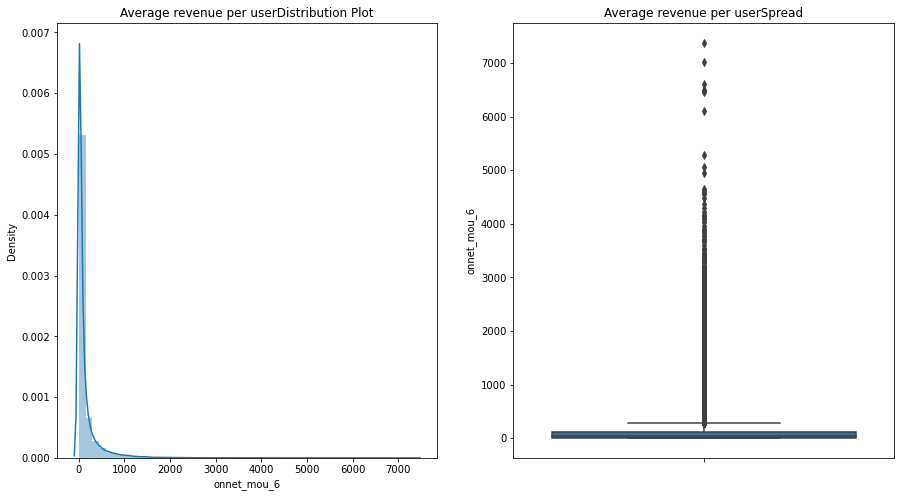

In [33]:
# Let us understand the distribution of average revenue per user. 
obj = DataUnderstanding(Telecom_DF)
obj.understandDistribution(Telecom_DF.onnet_mou_6, "Average revenue per user")

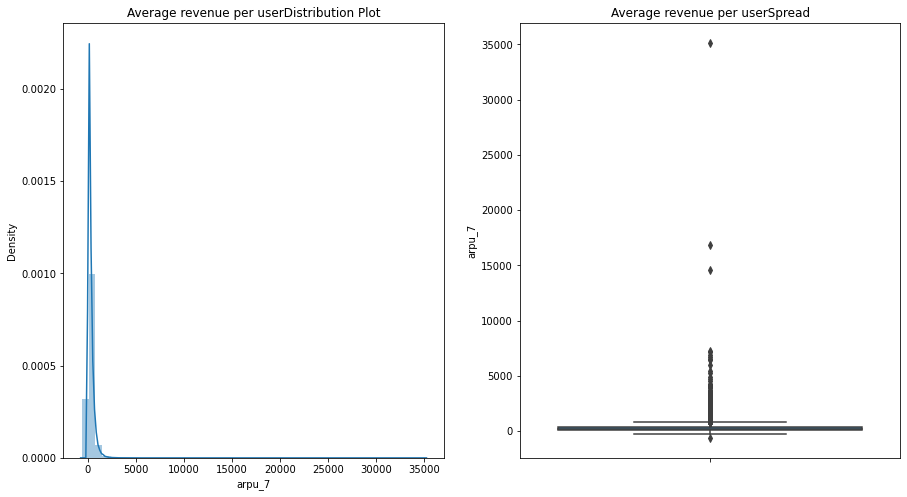

In [34]:
obj.understandDistribution(Telecom_DF.arpu_7, "Average revenue per user")

The above graph is left skewed and <b>if we apply log to normalize the data, it gives error </b> because there are many values which are closer to zero and even lesser than 0. Hence we will be removing the negative values and will be replacing it with 0. 

In [35]:
Telecom_DF['arpu_8']=Telecom_DF['arpu_8'].mask(Telecom_DF['arpu_8'].lt(0),0)
Telecom_DF['arpu_7']=Telecom_DF['arpu_7'].mask(Telecom_DF['arpu_7'].lt(0),0)
Telecom_DF['arpu_6']=Telecom_DF['arpu_6'].mask(Telecom_DF['arpu_6'].lt(0),0)

In [36]:
Telecom_DF[categorical[0]].value_counts().count()

1

Check for class imbalance in the Categorical data. 

In [37]:
Telecom_DF[categorical].value_counts().count()

1285

In [38]:
len(categorical)

13

### Univariate Analysis on Categorical variables. 

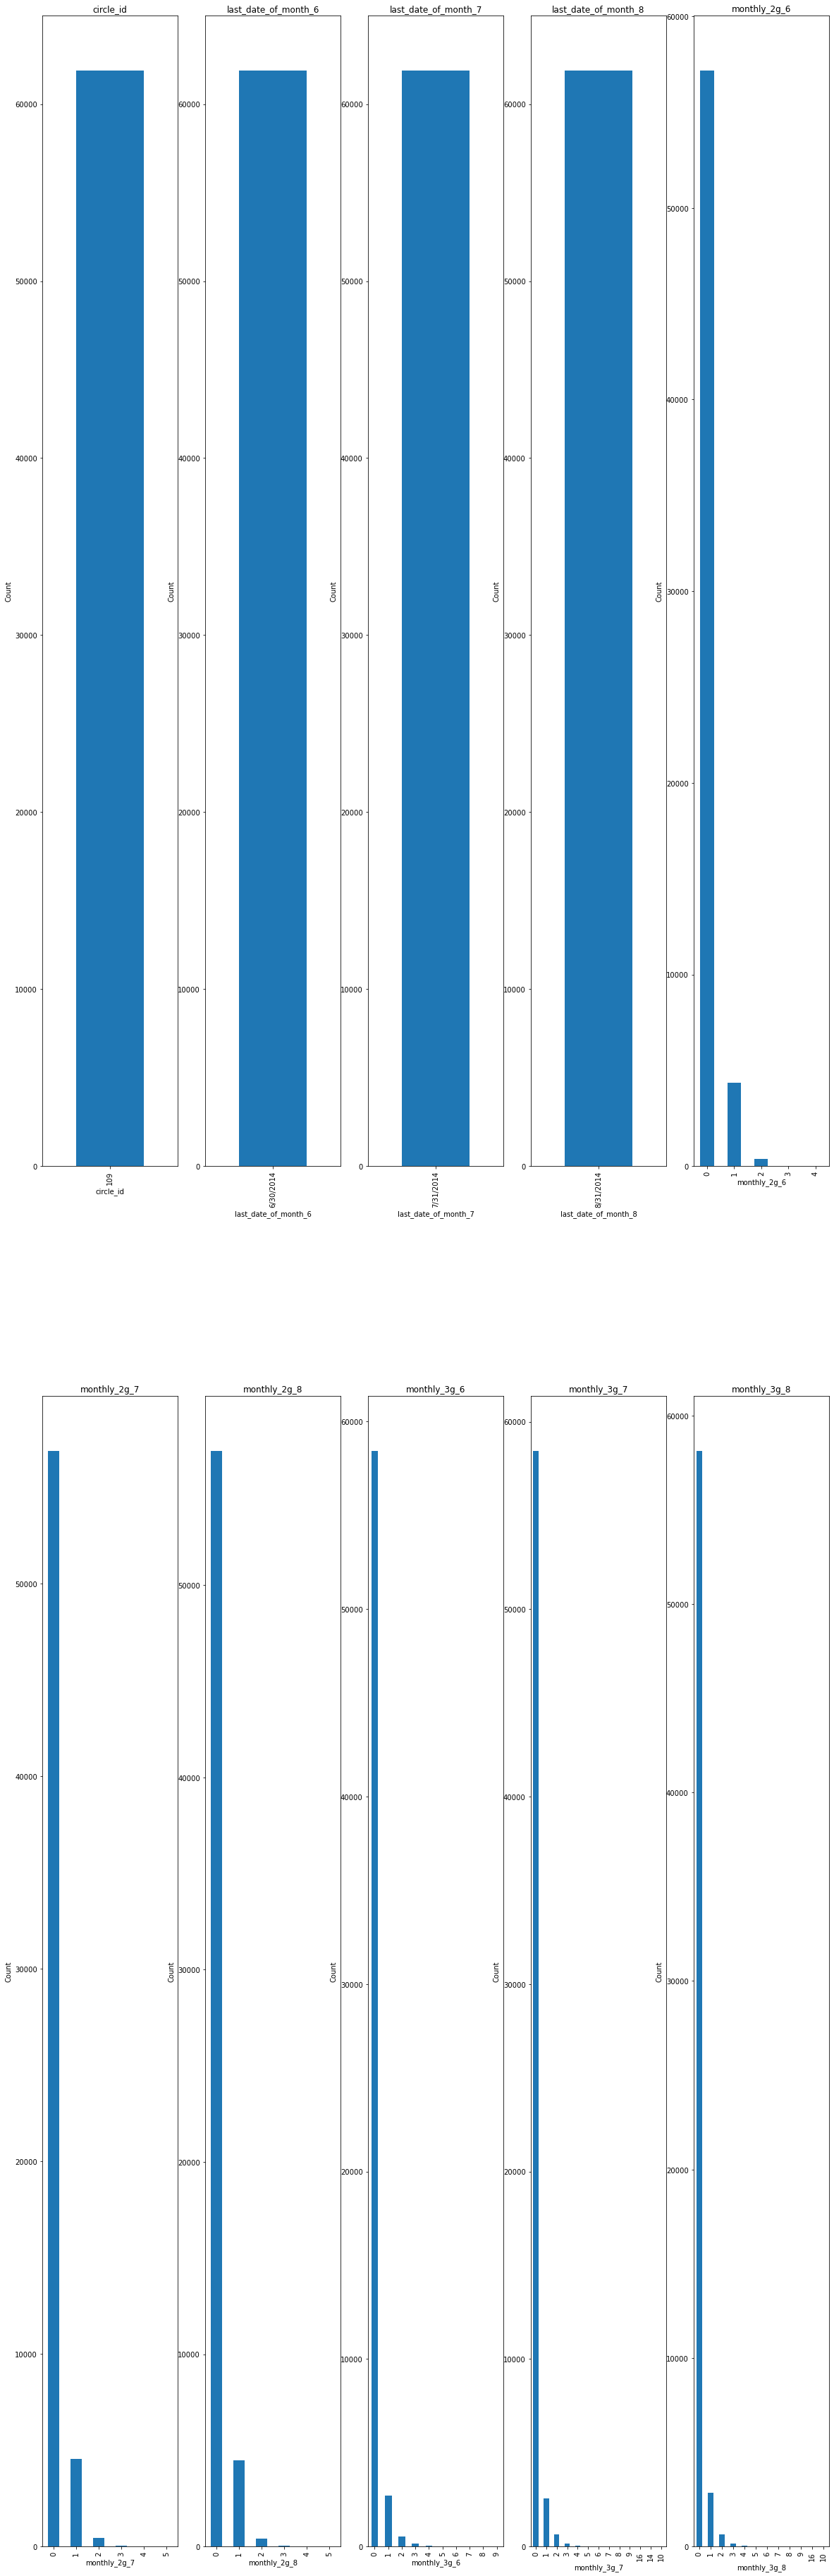

In [39]:
plt.figure(figsize=(20, 66)) 
column = 5
for value in enumerate(categorical[0:10], start = 1):
    plt.subplot(len(categorical) // column ,column,value[0])
    plt1 = Telecom_DF[value[1]].value_counts().plot(kind = 'bar')
    plt.title(value[1])
    plt1.set(xlabel = value[1], ylabel='Count')

From the above plot, we can infer that there are 0's in date columns which would affect our prediction. Also, circle_id is not used for prediction we remove it. 

In [40]:
 # Remove first column as it is just id.
Telecom_DF = Telecom_DF.drop('circle_id', axis = 1)

In [41]:
# Last date columns are same and they are also having 0's hence we remove it
Telecom_DF = Telecom_DF.drop(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8'], axis = 1)

It shows that there is a class imbalance in the above dataset. 

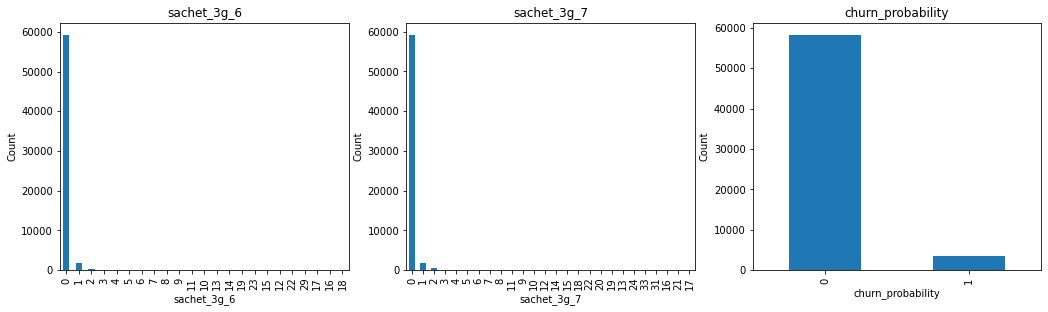

In [42]:
plt.figure(figsize=(30, 10)) 
column = 5
for value in enumerate(categorical[10:20], start = 1):
    plt.subplot(len(categorical) // column ,column,value[0])
    plt1 = Telecom_DF[value[1]].value_counts().plot(kind = 'bar')
    plt.title(value[1])
    plt1.set(xlabel = value[1], ylabel='Count')

There are more 0 values in the dataset. Hence Churn probabilities are also more for 0 class. There is a class imbalance.  

In [43]:
Telecom_DF.dtypes[Telecom_DF.dtypes == "O"]

date_of_last_rech_6    object
date_of_last_rech_7    object
date_of_last_rech_8    object
dtype: object

In [44]:
# We will remove "0" present in date
Telecom_DF = Telecom_DF[(Telecom_DF["date_of_last_rech_6"] != 0) & (Telecom_DF["date_of_last_rech_7"] != 0) & (Telecom_DF["date_of_last_rech_8"] != 0)]

### Univariate Analysis on Continuous variables. 

In [45]:
# We will get the day, month and year respectively.
# For this we will convert to datetime. 
Telecom_DF["date_of_last_rech_6"] = pd.to_datetime(Telecom_DF["date_of_last_rech_6"])
Telecom_DF["date_of_last_rech_7"] = pd.to_datetime(Telecom_DF["date_of_last_rech_7"])
Telecom_DF["date_of_last_rech_8"] = pd.to_datetime(Telecom_DF["date_of_last_rech_8"])

Telecom_DF['date_of_last_rech_6_Day'] = Telecom_DF['date_of_last_rech_6'].dt.day
Telecom_DF['date_of_last_rech_6_month'] = Telecom_DF['date_of_last_rech_6'].dt.month
Telecom_DF['date_of_last_rech_6_year'] = Telecom_DF['date_of_last_rech_6'].dt.year

Telecom_DF['date_of_last_rech_7_Day'] = Telecom_DF['date_of_last_rech_7'].dt.day
Telecom_DF['date_of_last_rech_7_month'] = Telecom_DF['date_of_last_rech_7'].dt.month
Telecom_DF['date_of_last_rech_7_year'] = Telecom_DF['date_of_last_rech_7'].dt.year

Telecom_DF['date_of_last_rech_8_Day'] = Telecom_DF['date_of_last_rech_8'].dt.day
Telecom_DF['date_of_last_rech_8_month'] = Telecom_DF['date_of_last_rech_8'].dt.month
Telecom_DF['date_of_last_rech_8_year'] = Telecom_DF['date_of_last_rech_8'].dt.year

In [46]:
# We will now drop the date colums. 
colsToRemove = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
Telecom_DF = Telecom_DF.drop(colsToRemove, axis = 1)

In [47]:
# Remove the last recharge columns as we have augmented the data.
for col in colsToRemove:
    continuous.remove(col)

In [48]:
# Since boxplot only allows numerical values, we remove object types. 
continuous_for_plot = []
for value in Telecom_DF[continuous]:
    if ((Telecom_DF[value].dtypes == "int64") or (Telecom_DF[value].dtypes == "float64")):
        continuous_for_plot.append(value)
continuous_for_plot

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_

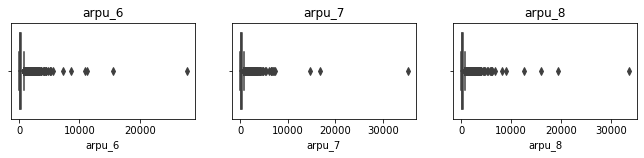

In [49]:
# Plotting to check if there are any outliers
plt.figure(figsize=(35, 25))
column = 9
for value in enumerate(continuous_for_plot[0:3], start = 1):
    plt.subplot(len(continuous_for_plot) // column ,column,value[0])
    plt.title(value[1])
    sb.boxplot(x=Telecom_DF[value[1]])

In [50]:
print("Number of outliers for Average revenue per user in the month of June are", Telecom_DF[Telecom_DF['arpu_6'] > 10000].shape[0])
print("Number of outliers for Average revenue per user in the month of July are", Telecom_DF[Telecom_DF['arpu_7'] > 10000].shape[0])
print("Number of outliers for Average revenue per user in the month of August are", Telecom_DF[Telecom_DF['arpu_8'] > 7500].shape[0])

Number of outliers for Average revenue per user in the month of June are 4
Number of outliers for Average revenue per user in the month of July are 3
Number of outliers for Average revenue per user in the month of August are 6


In [51]:
Telecom_DF = Telecom_DF[Telecom_DF['arpu_6'] < 10000]
Telecom_DF = Telecom_DF[Telecom_DF['arpu_7'] < 10000]
Telecom_DF = Telecom_DF[Telecom_DF['arpu_8'] < 7500]

In [52]:
Telecom_DF

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,churn_probability,date_of_last_rech_6_Day,date_of_last_rech_6_month,date_of_last_rech_6_year,date_of_last_rech_7_Day,date_of_last_rech_7_month,date_of_last_rech_7_year,date_of_last_rech_8_Day,date_of_last_rech_8_month,date_of_last_rech_8_year
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,...,0,22,6,2014,10,7,2014,24,8,2014
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,...,0,12,6,2014,10,7,2014,26,8,2014
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,...,0,11,6,2014,22,7,2014,24,8,2014
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,...,0,15,6,2014,21,7,2014,25,8,2014
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,...,0,25,6,2014,26,7,2014,30,8,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,14.96,...,0,18,6,2014,31,7,2014,31,8,2014
69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,0.00,...,0,28,6,2014,31,7,2014,27,8,2014
69996,372.088,258.374,279.782,77.13,68.44,78.44,335.54,227.94,263.84,0.00,...,0,25,6,2014,30,7,2014,29,8,2014
69997,238.575,245.414,145.062,14.01,7.64,6.71,30.34,16.68,12.56,25.06,...,0,29,6,2014,19,7,2014,26,8,2014


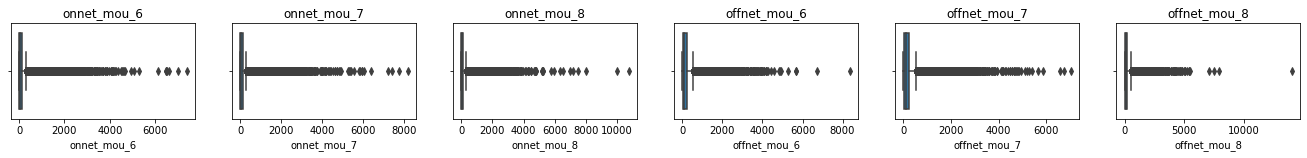

In [53]:
# Plotting to check if there are any outliers
plt.figure(figsize=(35, 25))
column = 9
for value in enumerate(continuous_for_plot[3:9], start = 1):
    plt.subplot(len(continuous_for_plot) // column ,column,value[0])
    plt.title(value[1])
    sb.boxplot(x=Telecom_DF[value[1]])

There seems to be non linearity here. If we remove outliers from onnet_mou_7, we might lose data. Hence we remove outliers for offnet

In [54]:
print("All kind of calls outside the operator T network in the month of June are", Telecom_DF[Telecom_DF['offnet_mou_6'] > 5000].shape[0])
print("All kind of calls outside the operator T network in the month of July are", Telecom_DF[Telecom_DF['offnet_mou_7'] > 6000].shape[0])
print("All kind of calls outside the operator T network in the month of August are", Telecom_DF[Telecom_DF['offnet_mou_8'] > 6500].shape[0])

All kind of calls outside the operator T network in the month of June are 5
All kind of calls outside the operator T network in the month of July are 3
All kind of calls outside the operator T network in the month of August are 4


In [55]:
Telecom_DF = Telecom_DF[Telecom_DF['offnet_mou_6'] < 5000]
Telecom_DF = Telecom_DF[Telecom_DF['offnet_mou_7'] < 6000]
Telecom_DF = Telecom_DF[Telecom_DF['offnet_mou_8'] < 6500]

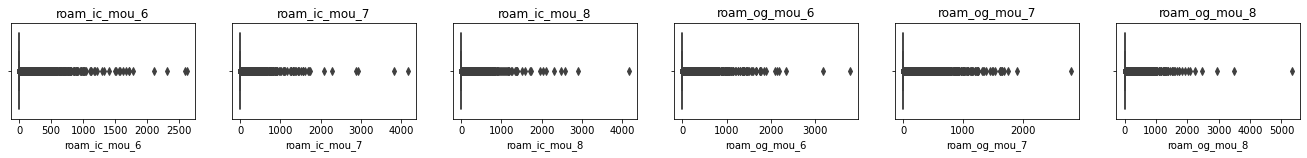

In [56]:
# Plotting to check if there are any outliers
plt.figure(figsize=(35, 25))
column = 9
for value in enumerate(continuous_for_plot[9:15], start = 1):
    plt.subplot(len(continuous_for_plot) // column ,column,value[0])
    plt.title(value[1])
    sb.boxplot(x=Telecom_DF[value[1]])

In [57]:
print("Customer is in roaming zone during the incoming call in the month of June are", Telecom_DF[Telecom_DF['roam_ic_mou_6'] > 1900].shape[0])
print("Customer is in roaming zone during the incoming call in the month of July are", Telecom_DF[Telecom_DF['roam_ic_mou_7'] > 2000].shape[0])
print("Customer is in roaming zone during the incoming call in the month of August are", Telecom_DF[Telecom_DF['roam_ic_mou_8'] > 2800].shape[0])
print("Customer is in roaming zone during the outgoing call in the month of June are", Telecom_DF[Telecom_DF['roam_og_mou_6'] > 2200].shape[0])
print("Customer is in roaming zone during the outgoing call in the month of July are", Telecom_DF[Telecom_DF['roam_og_mou_7'] > 1800].shape[0])
print("Customer is in roaming zone during the outgoing call in the month of August are", Telecom_DF[Telecom_DF['roam_og_mou_8'] > 2200].shape[0])

Customer is in roaming zone during the incoming call in the month of June are 4
Customer is in roaming zone during the incoming call in the month of July are 6
Customer is in roaming zone during the incoming call in the month of August are 2
Customer is in roaming zone during the outgoing call in the month of June are 3
Customer is in roaming zone during the outgoing call in the month of July are 2
Customer is in roaming zone during the outgoing call in the month of August are 5


In [58]:
# Remove the outliers
Telecom_DF = Telecom_DF[Telecom_DF['roam_og_mou_6'] < 1900]
Telecom_DF = Telecom_DF[Telecom_DF['roam_og_mou_7'] < 2000]
Telecom_DF = Telecom_DF[Telecom_DF['roam_og_mou_8'] < 2800]
Telecom_DF = Telecom_DF[Telecom_DF['roam_og_mou_6'] < 2200]
Telecom_DF = Telecom_DF[Telecom_DF['roam_og_mou_7'] < 1800]
Telecom_DF = Telecom_DF[Telecom_DF['roam_og_mou_8'] < 2200]

In [59]:
Telecom_DF

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,churn_probability,date_of_last_rech_6_Day,date_of_last_rech_6_month,date_of_last_rech_6_year,date_of_last_rech_7_Day,date_of_last_rech_7_month,date_of_last_rech_7_year,date_of_last_rech_8_Day,date_of_last_rech_8_month,date_of_last_rech_8_year
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,...,0,22,6,2014,10,7,2014,24,8,2014
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,...,0,12,6,2014,10,7,2014,26,8,2014
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,...,0,11,6,2014,22,7,2014,24,8,2014
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,...,0,15,6,2014,21,7,2014,25,8,2014
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,...,0,25,6,2014,26,7,2014,30,8,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,14.96,...,0,18,6,2014,31,7,2014,31,8,2014
69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,0.00,...,0,28,6,2014,31,7,2014,27,8,2014
69996,372.088,258.374,279.782,77.13,68.44,78.44,335.54,227.94,263.84,0.00,...,0,25,6,2014,30,7,2014,29,8,2014
69997,238.575,245.414,145.062,14.01,7.64,6.71,30.34,16.68,12.56,25.06,...,0,29,6,2014,19,7,2014,26,8,2014


In [60]:
continuous_for_plot

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_

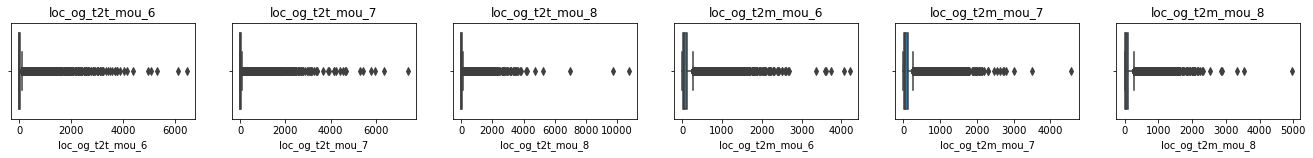

In [61]:
# Plotting to check if there are any outliers
plt.figure(figsize=(35, 25))
column = 9
for value in enumerate(continuous_for_plot[15:21], start = 1):
    plt.subplot(len(continuous_for_plot) // column ,column,value[0])
    plt.title(value[1])
    sb.boxplot(x=Telecom_DF[value[1]])

In [62]:
len(continuous_for_plot)

111

In [63]:
continuous_for_plot[15:21]

['loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8']

In [64]:
print("Local calls with T to T outgoing in the month of June are", Telecom_DF[Telecom_DF['loc_og_t2t_mou_6'] > 4200].shape[0])
print("Local calls with T to T outgoing in the month of July are", Telecom_DF[Telecom_DF['loc_og_t2t_mou_7'] > 4500].shape[0])
print("Local calls with T to T outgoing in the month of August are", Telecom_DF[Telecom_DF['loc_og_t2t_mou_8'] > 4200].shape[0])
print("Local calls with T to other operator mobile outgoing in the month of June are", Telecom_DF[Telecom_DF['loc_og_t2m_mou_6'] > 3000].shape[0])
print("Local calls with T to other operator mobile outgoing in the month of July are", Telecom_DF[Telecom_DF['loc_og_t2m_mou_7'] > 2800].shape[0])
print("Local calls with T to other operator mobile outgoing in the month of August are", Telecom_DF[Telecom_DF['loc_og_t2m_mou_8'] > 2700].shape[0])

Local calls with T to T outgoing in the month of June are 6
Local calls with T to T outgoing in the month of July are 9
Local calls with T to T outgoing in the month of August are 6
Local calls with T to other operator mobile outgoing in the month of June are 6
Local calls with T to other operator mobile outgoing in the month of July are 3
Local calls with T to other operator mobile outgoing in the month of August are 5


In [65]:
Telecom_DF = Telecom_DF[Telecom_DF['loc_og_t2t_mou_6'] < 4200]
Telecom_DF = Telecom_DF[Telecom_DF['loc_og_t2t_mou_7'] < 4500]
Telecom_DF = Telecom_DF[Telecom_DF['loc_og_t2t_mou_8'] < 4200]
Telecom_DF = Telecom_DF[Telecom_DF['loc_og_t2m_mou_6'] < 3000]
Telecom_DF = Telecom_DF[Telecom_DF['loc_og_t2m_mou_7'] < 2800]
Telecom_DF = Telecom_DF[Telecom_DF['loc_og_t2m_mou_8'] < 2700]

In [66]:
Telecom_DF

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,churn_probability,date_of_last_rech_6_Day,date_of_last_rech_6_month,date_of_last_rech_6_year,date_of_last_rech_7_Day,date_of_last_rech_7_month,date_of_last_rech_7_year,date_of_last_rech_8_Day,date_of_last_rech_8_month,date_of_last_rech_8_year
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,...,0,22,6,2014,10,7,2014,24,8,2014
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,...,0,12,6,2014,10,7,2014,26,8,2014
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,...,0,11,6,2014,22,7,2014,24,8,2014
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,...,0,15,6,2014,21,7,2014,25,8,2014
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,...,0,25,6,2014,26,7,2014,30,8,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,14.96,...,0,18,6,2014,31,7,2014,31,8,2014
69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,0.00,...,0,28,6,2014,31,7,2014,27,8,2014
69996,372.088,258.374,279.782,77.13,68.44,78.44,335.54,227.94,263.84,0.00,...,0,25,6,2014,30,7,2014,29,8,2014
69997,238.575,245.414,145.062,14.01,7.64,6.71,30.34,16.68,12.56,25.06,...,0,29,6,2014,19,7,2014,26,8,2014


In [67]:
continuous_for_plot[21:57]

['loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7']

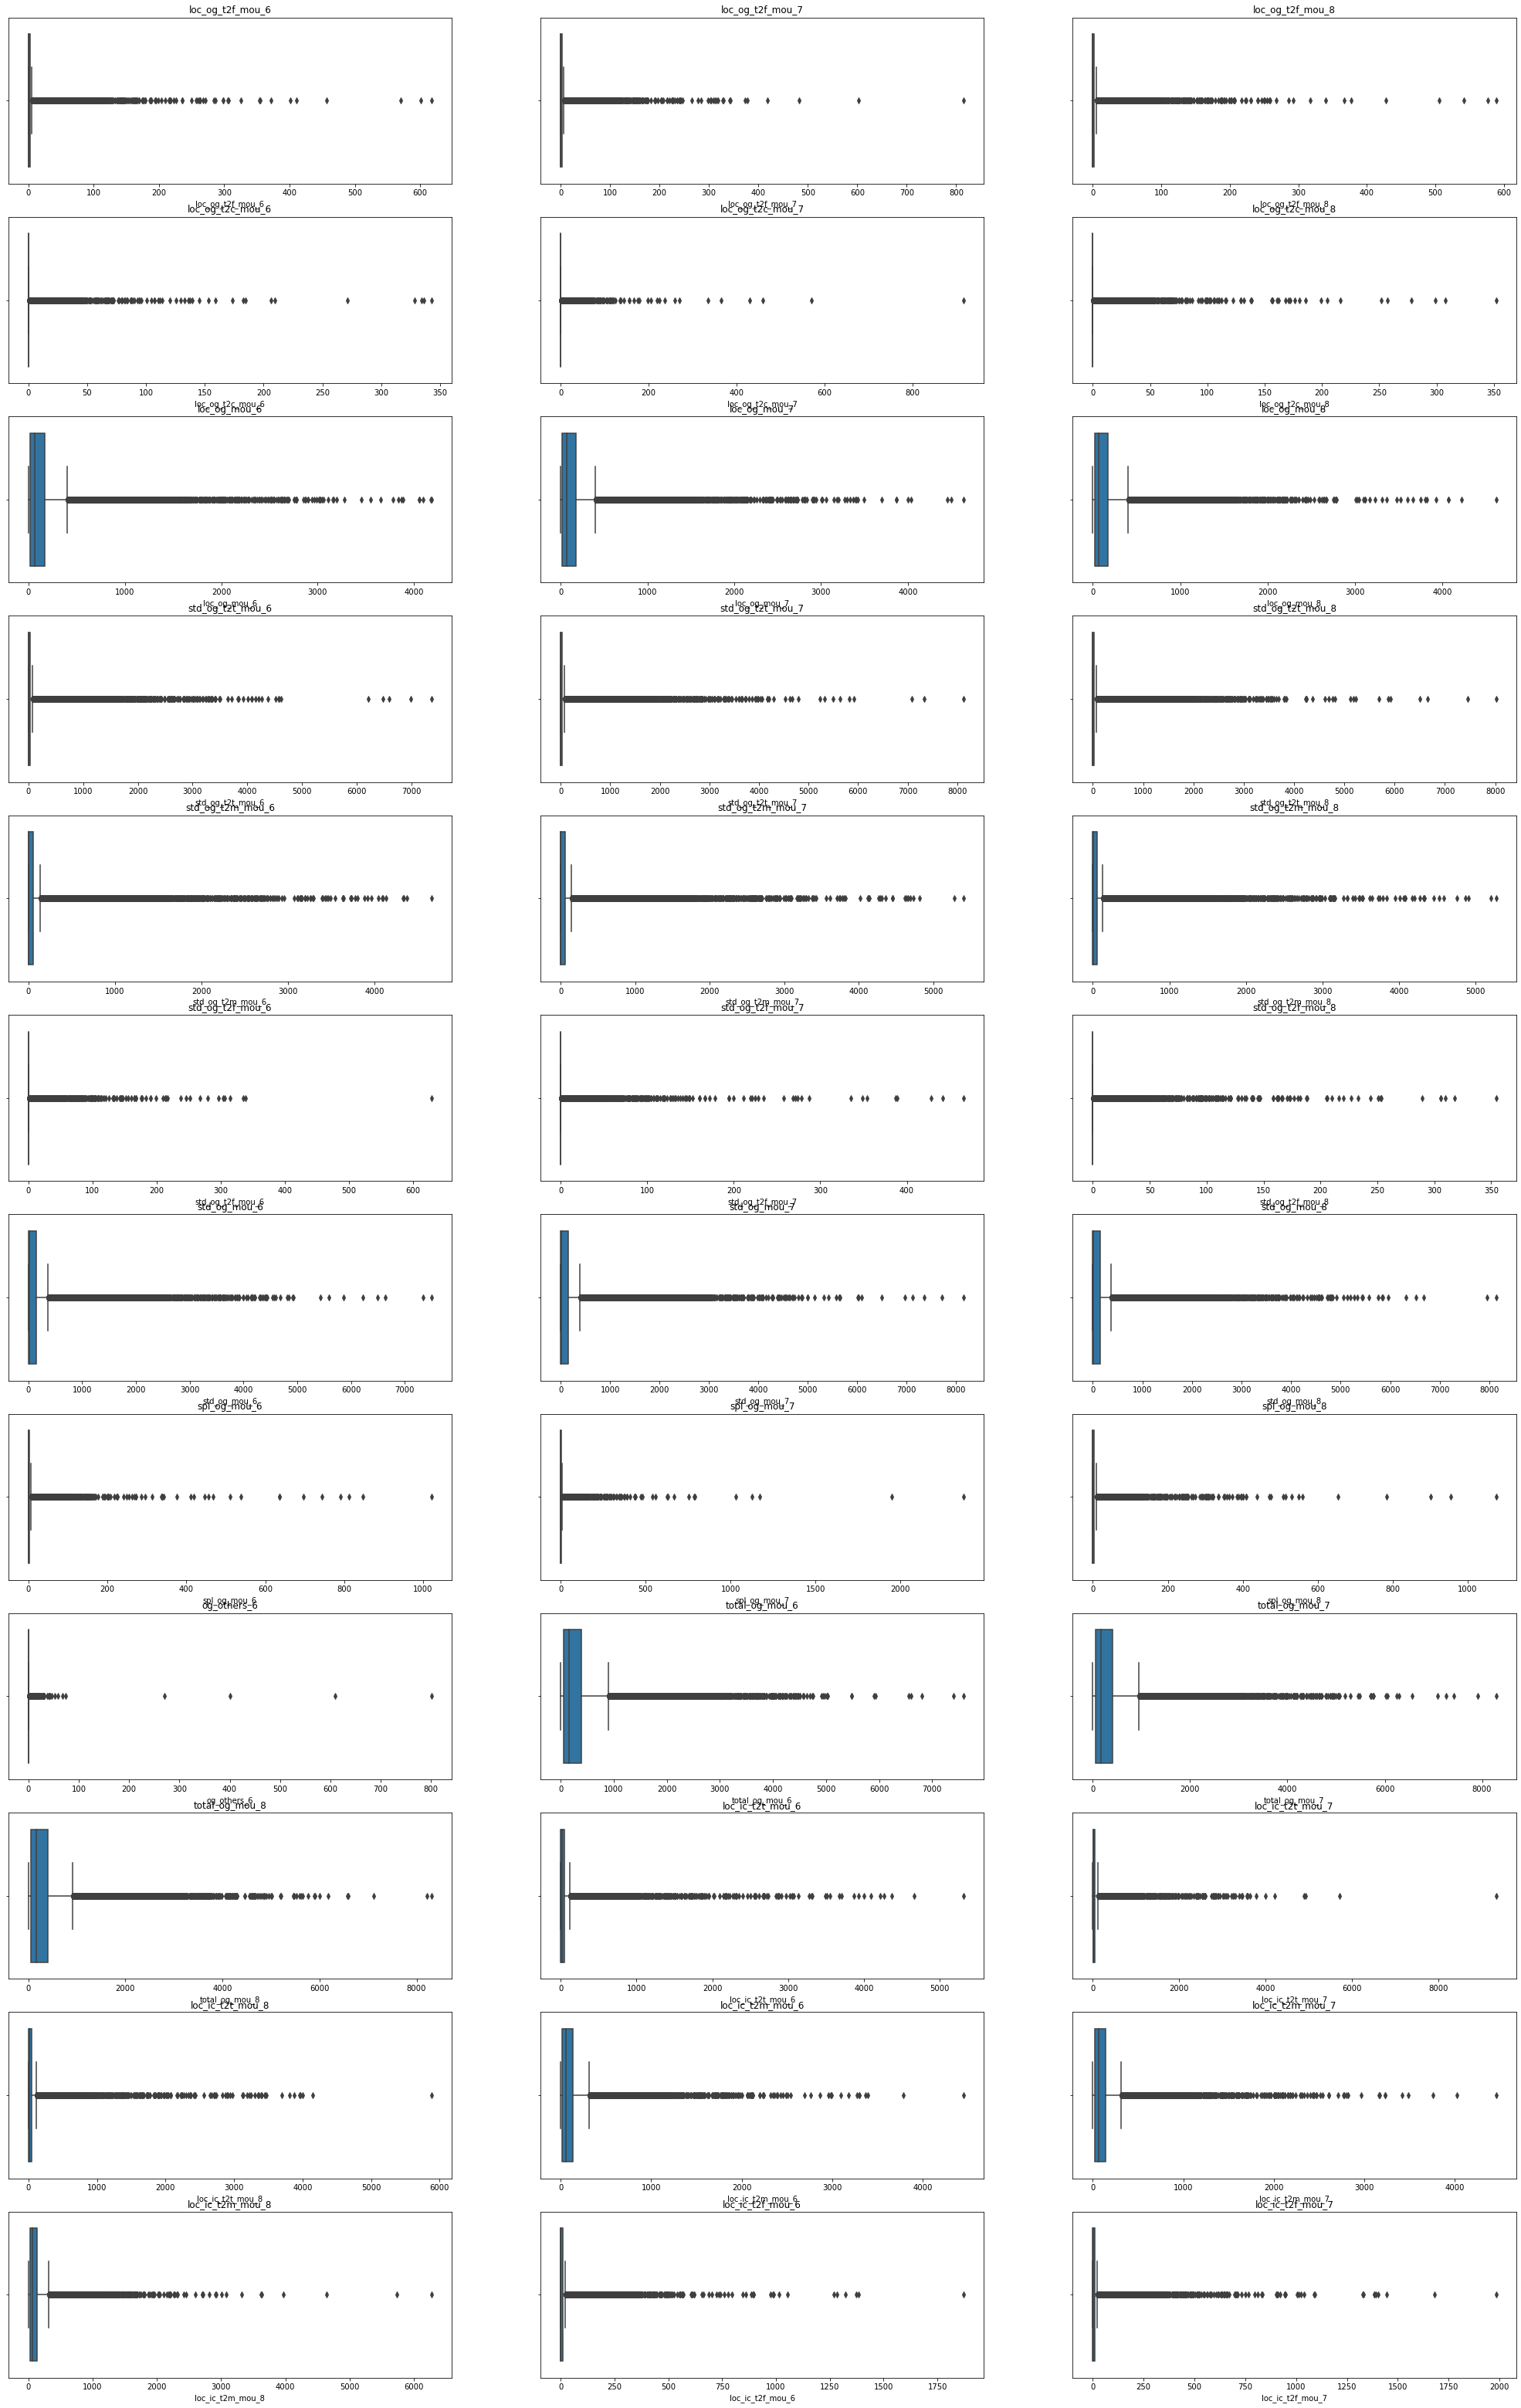

In [68]:
# Plotting to check if there are any outliers
plt.figure(figsize=(35, 175))
column = 3
for value in enumerate(continuous_for_plot[21:57], start = 1):
    plt.subplot(len(continuous_for_plot) // column ,column,value[0])
    plt.title(value[1])
    sb.boxplot(x=Telecom_DF[value[1]])

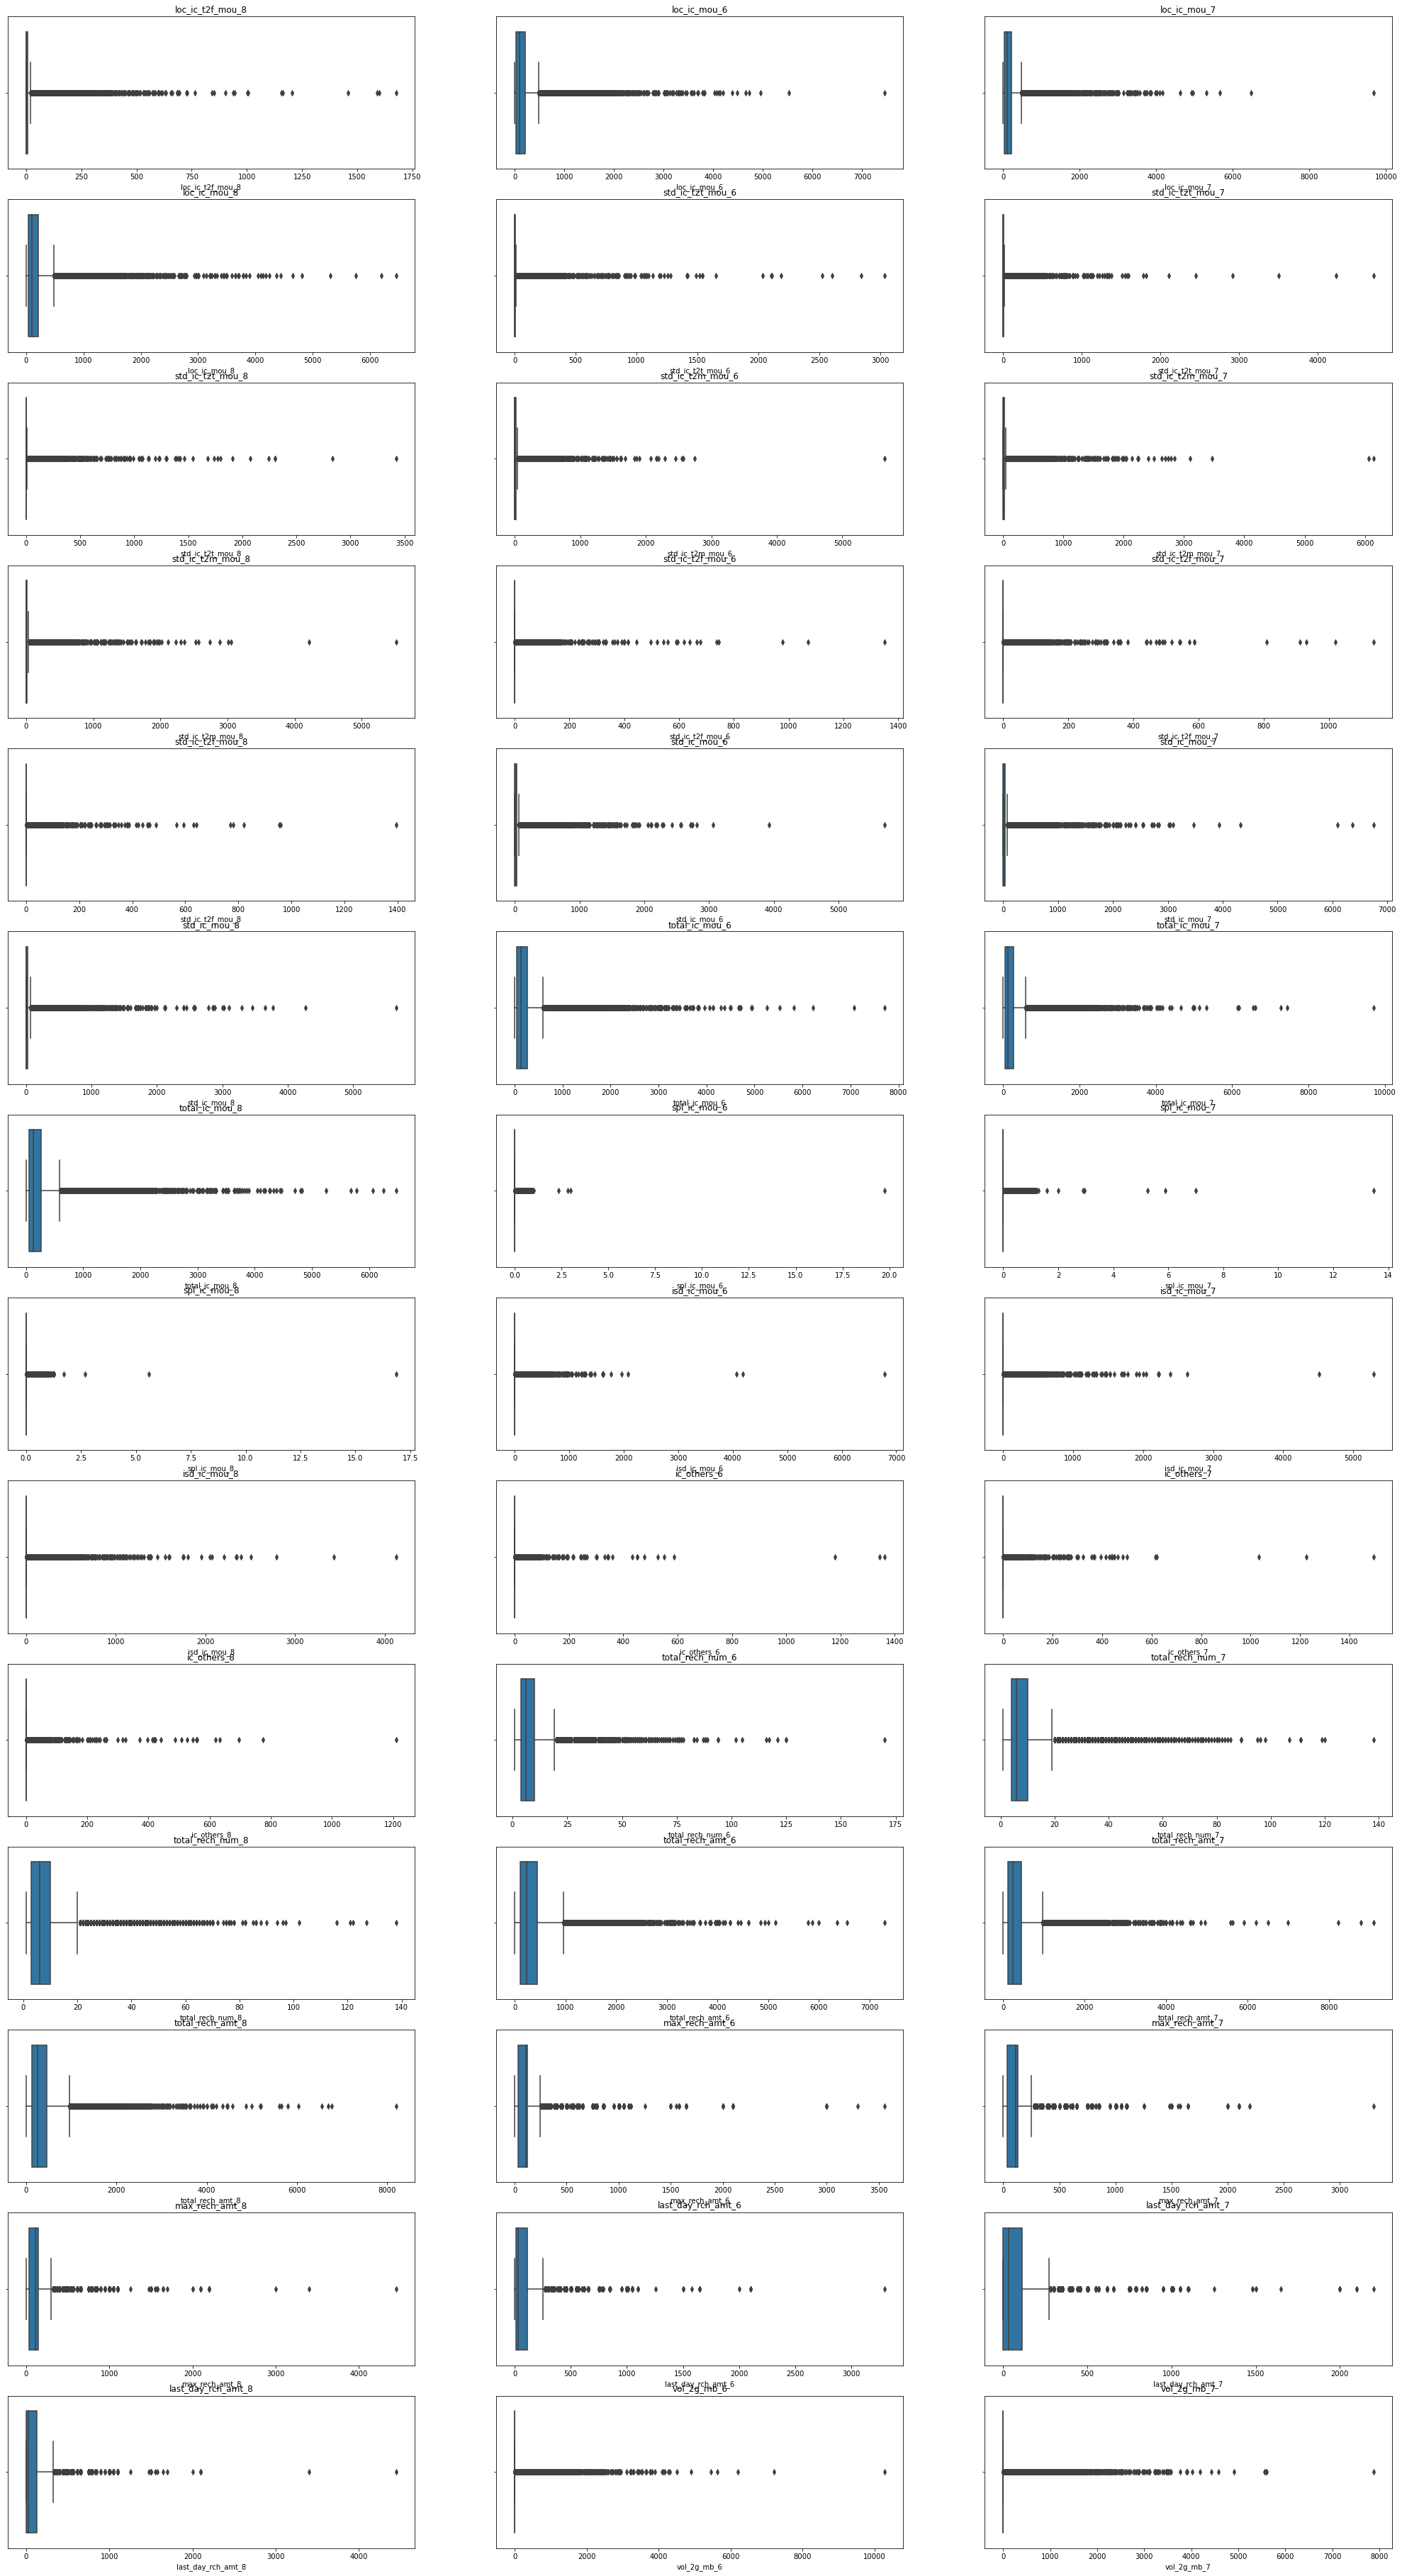

In [69]:
# Plotting to check if there are any outliers
plt.figure(figsize=(35, 175))
column = 3
for value in enumerate(continuous_for_plot[57:99], start = 1):
    plt.subplot(len(continuous_for_plot) // column ,column,value[0])
    plt.title(value[1])
    sb.boxplot(x=Telecom_DF[value[1]])

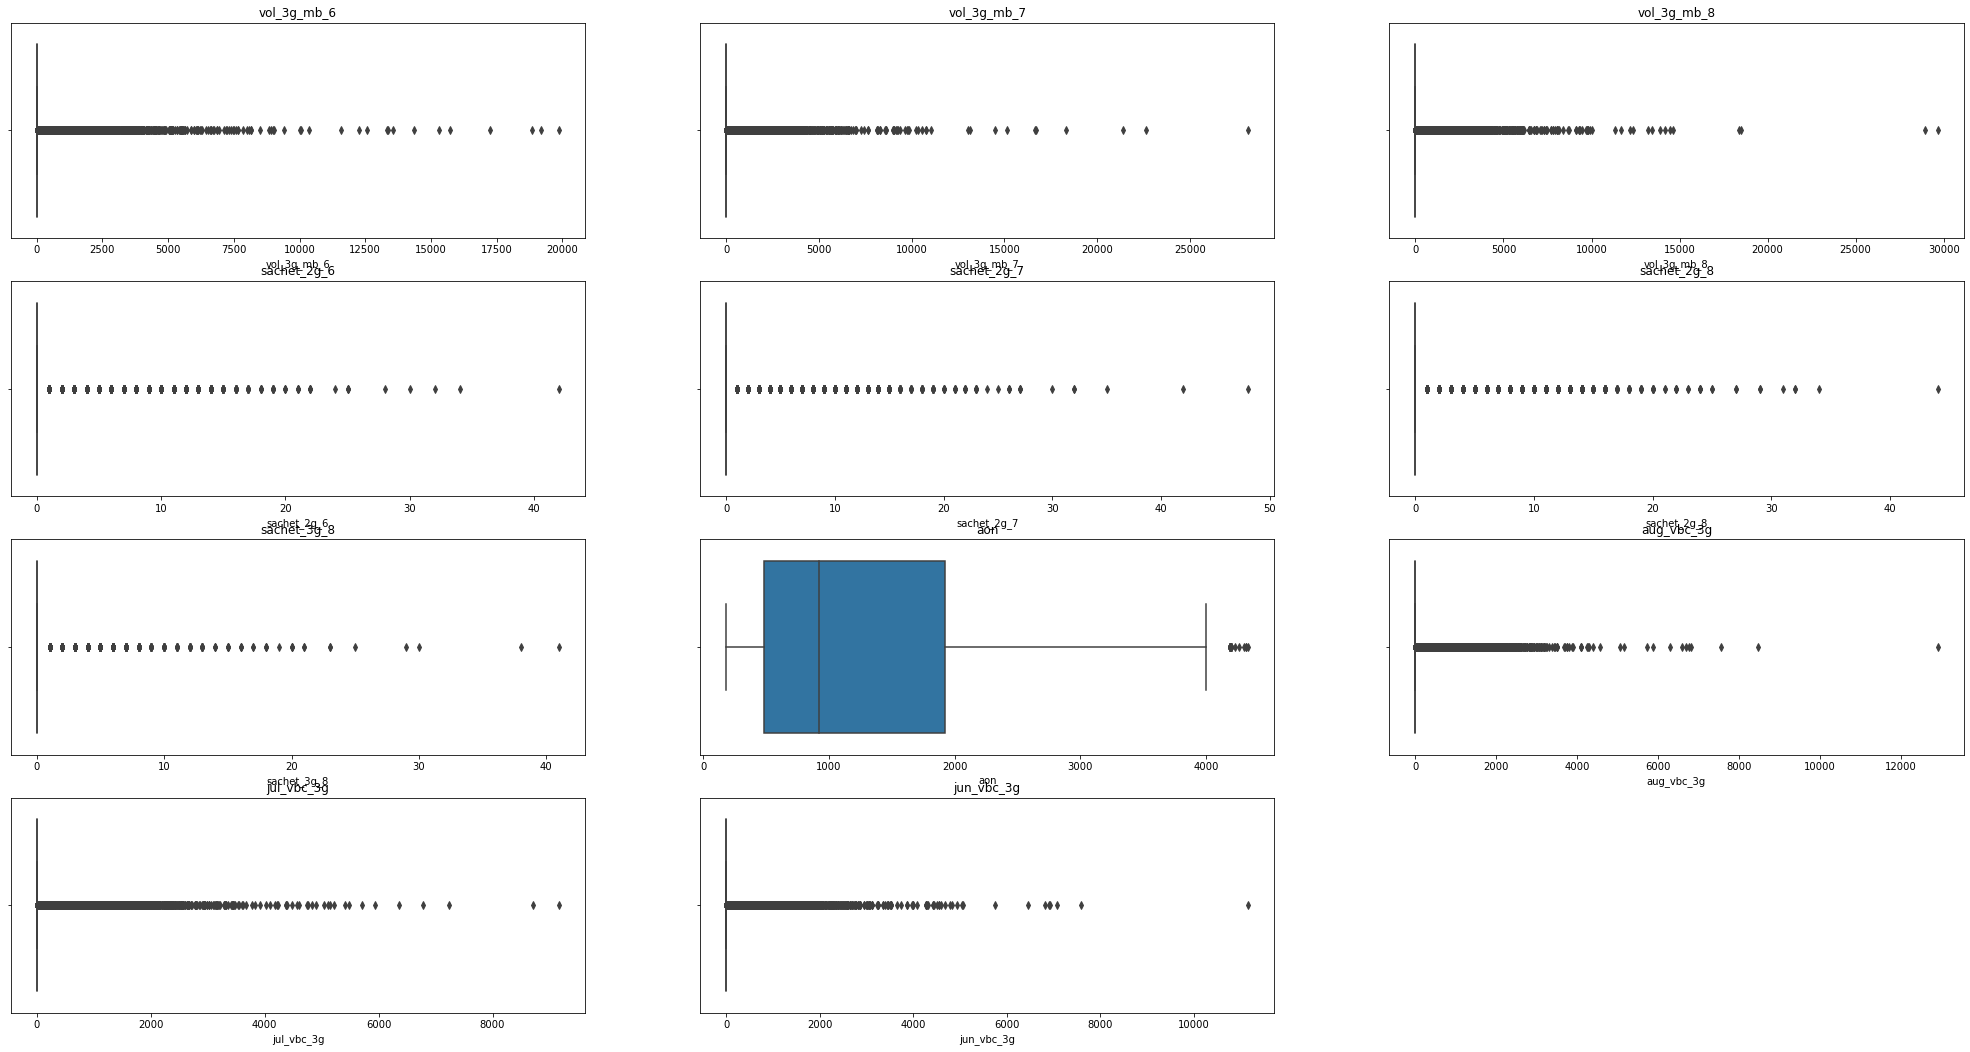

In [70]:
# Plotting to check if there are any outliers
plt.figure(figsize=(35, 175))
column = 3
for value in enumerate(continuous_for_plot[100:], start = 1):
    plt.subplot(len(continuous_for_plot) // column ,column,value[0])
    plt.title(value[1])
    sb.boxplot(x=Telecom_DF[value[1]])

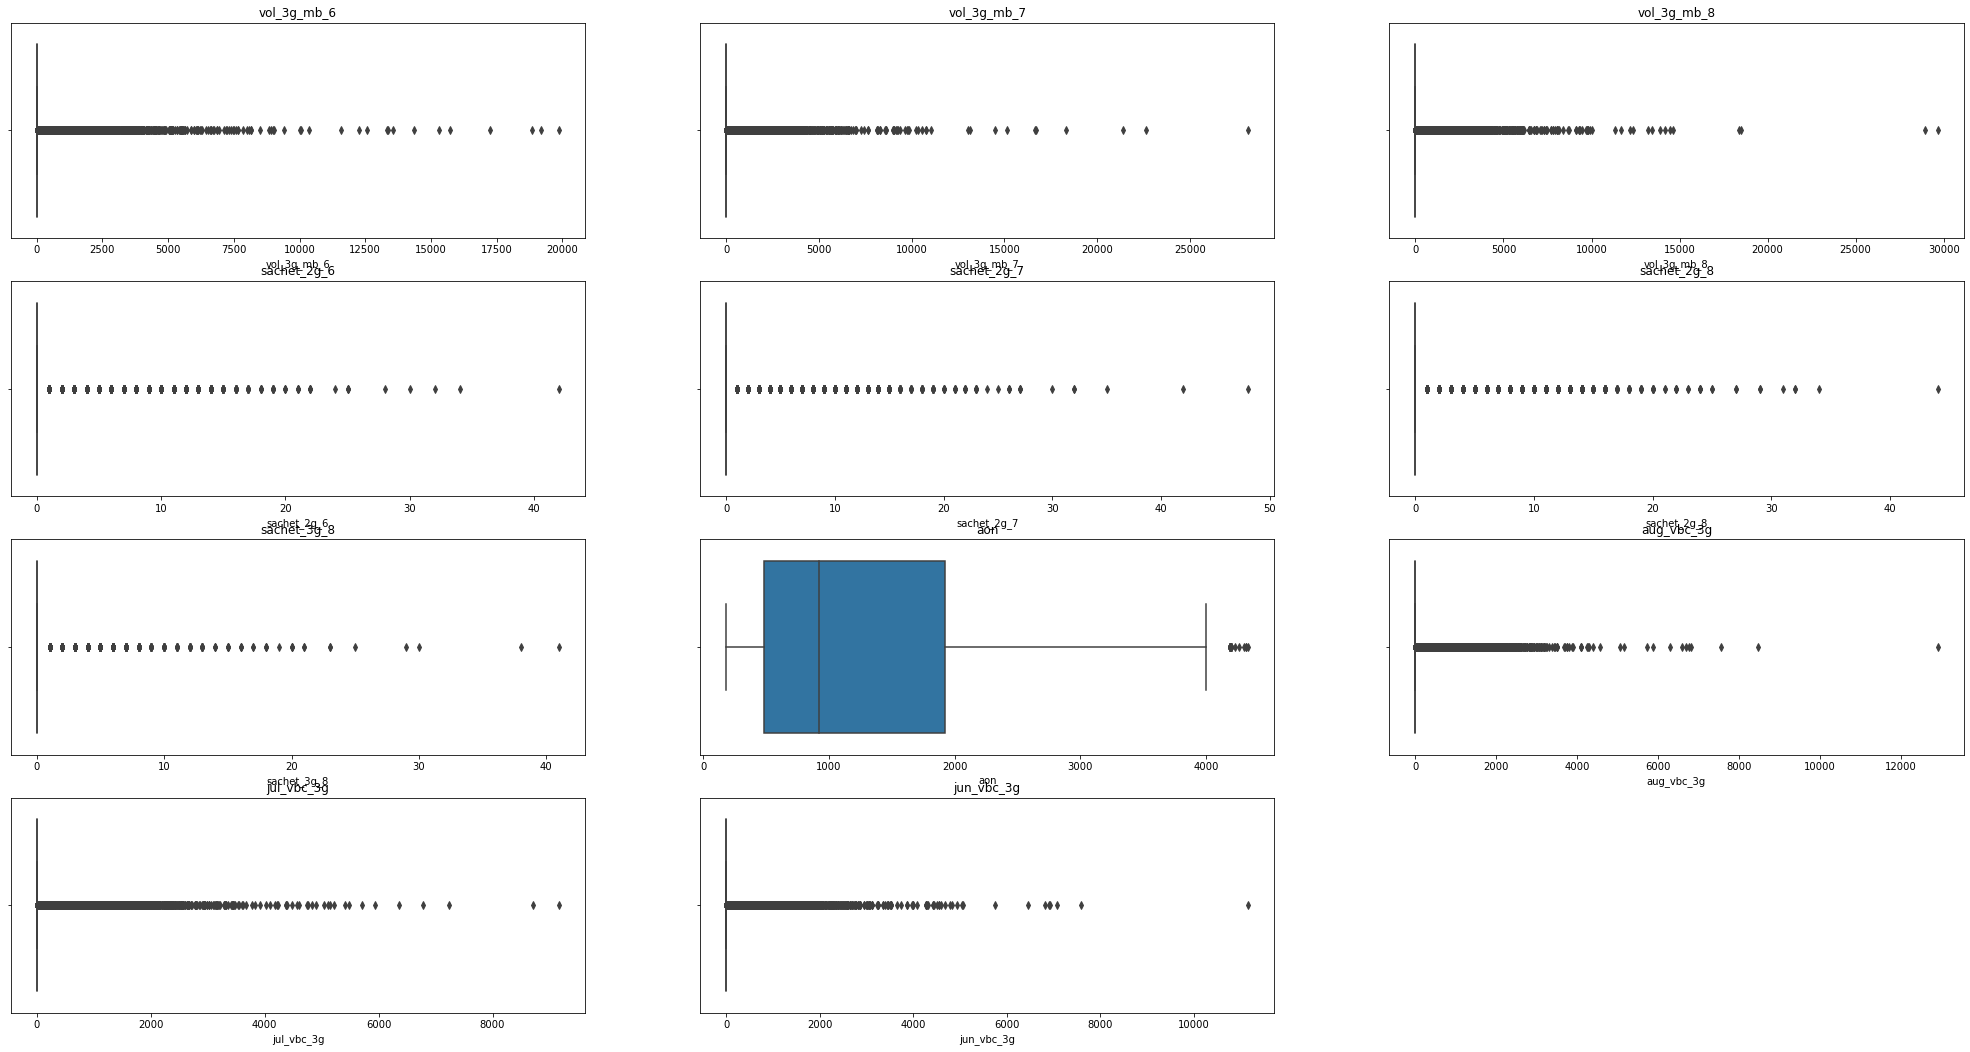

In [71]:
# Plotting to check if there are any outliers
plt.figure(figsize=(35, 175))
column = 3
for value in enumerate(continuous_for_plot[100:], start = 1):
    plt.subplot(len(continuous_for_plot) // column ,column,value[0])
    plt.title(value[1])
    sb.boxplot(x=Telecom_DF[value[1]])

one common thing thing in the outliers is that the last 5 values of the columns have the maximum of them. So we remove last 5 max values from the dataset. 

In [72]:
Telecom_DF.sort_values('loc_og_t2f_mou_6')['loc_og_t2f_mou_6']

0          0.00
40505      0.00
40507      0.00
40508      0.00
40509      0.00
          ...  
40347    410.53
54560    456.74
57732    570.43
42363    600.81
48894    617.58
Name: loc_og_t2f_mou_6, Length: 61844, dtype: float64

In [73]:
Telecom_DF

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,churn_probability,date_of_last_rech_6_Day,date_of_last_rech_6_month,date_of_last_rech_6_year,date_of_last_rech_7_Day,date_of_last_rech_7_month,date_of_last_rech_7_year,date_of_last_rech_8_Day,date_of_last_rech_8_month,date_of_last_rech_8_year
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,...,0,22,6,2014,10,7,2014,24,8,2014
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,...,0,12,6,2014,10,7,2014,26,8,2014
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,...,0,11,6,2014,22,7,2014,24,8,2014
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,...,0,15,6,2014,21,7,2014,25,8,2014
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,...,0,25,6,2014,26,7,2014,30,8,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,14.96,...,0,18,6,2014,31,7,2014,31,8,2014
69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,0.00,...,0,28,6,2014,31,7,2014,27,8,2014
69996,372.088,258.374,279.782,77.13,68.44,78.44,335.54,227.94,263.84,0.00,...,0,25,6,2014,30,7,2014,29,8,2014
69997,238.575,245.414,145.062,14.01,7.64,6.71,30.34,16.68,12.56,25.06,...,0,29,6,2014,19,7,2014,26,8,2014


In [74]:
for value in continuous_for_plot[21:]:
    Telecom_DF = Telecom_DF.sort_values(value)
    Telecom_DF = Telecom_DF.iloc[:-5]

In [75]:
Telecom_DF

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,churn_probability,date_of_last_rech_6_Day,date_of_last_rech_6_month,date_of_last_rech_6_year,date_of_last_rech_7_Day,date_of_last_rech_7_month,date_of_last_rech_7_year,date_of_last_rech_8_Day,date_of_last_rech_8_month,date_of_last_rech_8_year
52555,117.575,148.457,132.915,0.00,15.63,14.43,59.01,109.61,106.23,0.0,...,0,30,6,2014,30,7,2014,26,8,2014
67382,1077.634,1285.430,1294.585,150.61,268.39,117.66,2187.54,2486.59,2665.44,0.0,...,0,29,6,2014,29,7,2014,30,8,2014
56142,115.699,213.482,26.823,0.71,0.00,0.00,94.41,201.03,16.63,0.0,...,0,22,6,2014,31,7,2014,3,8,2014
34206,121.183,129.221,123.087,19.39,9.14,15.53,167.39,138.73,167.93,0.0,...,0,20,6,2014,17,7,2014,27,8,2014
31895,87.113,18.155,53.467,12.99,3.46,5.19,36.08,11.53,38.44,0.0,...,0,25,6,2014,20,7,2014,25,8,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68802,1912.609,1892.155,2601.087,58.88,36.34,65.66,168.39,177.24,724.94,0.0,...,0,30,6,2014,31,7,2014,31,8,2014
40930,1009.918,1715.123,1877.160,34.36,75.91,41.04,291.81,280.06,169.73,0.0,...,0,26,6,2014,28,7,2014,24,8,2014
14966,1778.763,1156.326,893.303,17.43,1.70,19.69,20.94,0.78,32.76,0.0,...,0,28,6,2014,26,7,2014,30,8,2014
36321,896.978,1605.983,982.280,10.58,19.73,25.61,40.76,43.11,107.58,0.0,...,0,21,6,2014,31,7,2014,26,8,2014


### Segmented Univariate Analysis

In [76]:
# Let us recalculate continuous and categorical variables as we had edited many. 
obj = DataUnderstanding(Telecom_DF)
continuous, categorical = obj.detectContinuousCategorical()

arpu_6 : 56280
arpu_7 : 56417
arpu_8 : 56062
onnet_mou_6 : 19076
onnet_mou_7 : 19320
onnet_mou_8 : 18917
offnet_mou_6 : 25079
offnet_mou_7 : 25234
offnet_mou_8 : 25070
roam_ic_mou_6 : 5018
roam_ic_mou_7 : 4022
roam_ic_mou_8 : 4076
roam_og_mou_6 : 6103
roam_og_mou_7 : 4936
roam_og_mou_8 : 4961
loc_og_t2t_mou_6 : 11097
loc_og_t2t_mou_7 : 11095
loc_og_t2t_mou_8 : 11034
loc_og_t2m_mou_6 : 17252
loc_og_t2m_mou_7 : 17241
loc_og_t2m_mou_8 : 17280
loc_og_t2f_mou_6 : 3241
loc_og_t2f_mou_7 : 3254
loc_og_t2f_mou_8 : 3211
loc_og_t2c_mou_6 : 1865
loc_og_t2c_mou_7 : 2022
loc_og_t2c_mou_8 : 2129
loc_og_mou_6 : 21518
loc_og_mou_7 : 21495
loc_og_mou_8 : 21454
std_og_t2t_mou_6 : 13613
std_og_t2t_mou_7 : 13969
std_og_t2t_mou_8 : 13686
std_og_t2m_mou_6 : 15090
std_og_t2m_mou_7 : 15430
std_og_t2m_mou_8 : 15096
std_og_t2f_mou_6 : 1955
std_og_t2f_mou_7 : 1870
std_og_t2f_mou_8 : 1845
std_og_mou_6 : 20421
std_og_mou_7 : 20889
std_og_mou_8 : 20496
spl_og_mou_6 : 3327
spl_og_mou_7 : 3678
spl_og_mou_8 : 3703
og_o

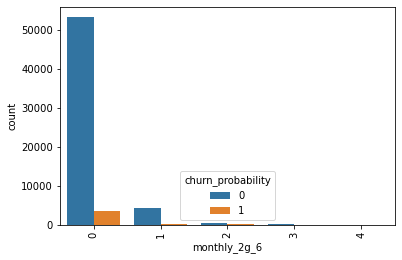

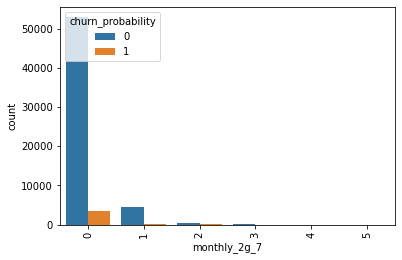

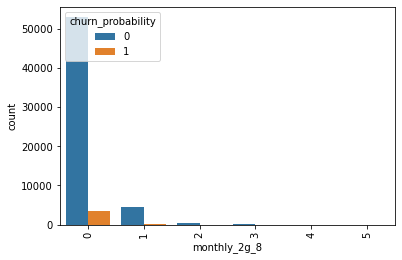

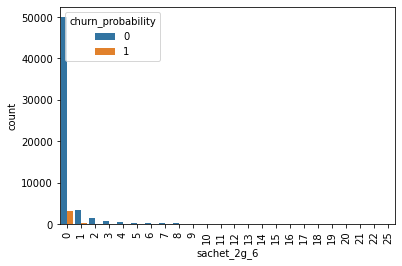

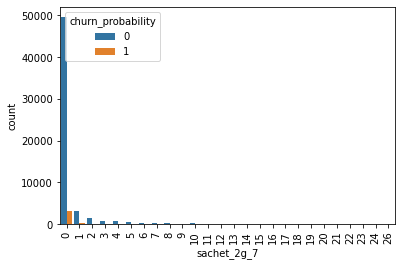

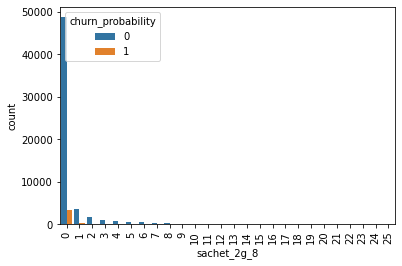

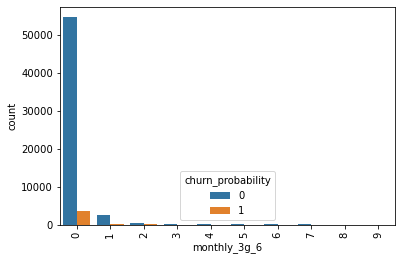

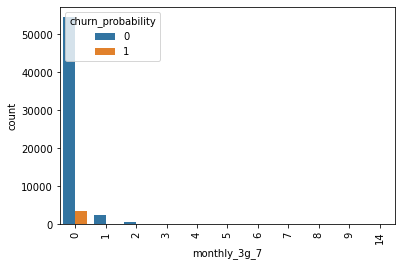

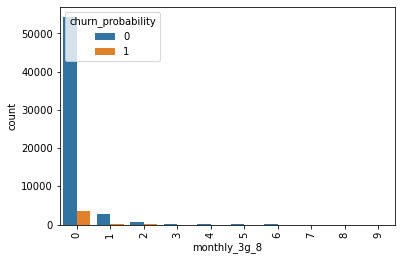

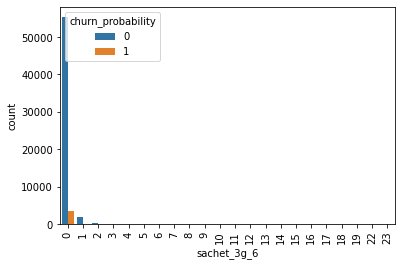

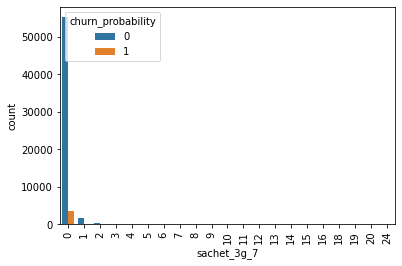

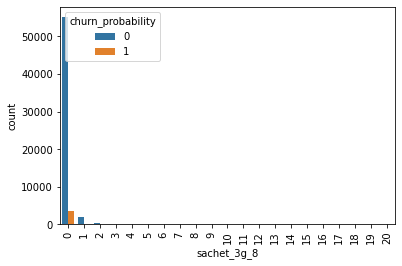

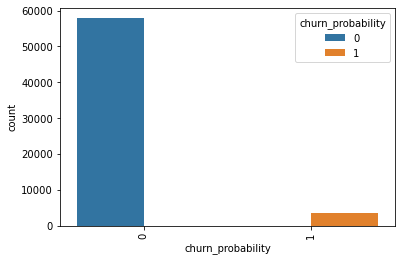

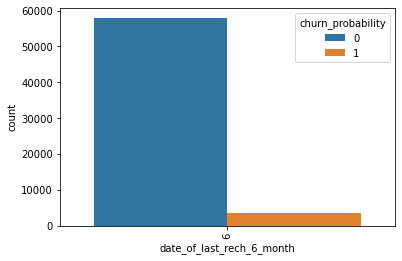

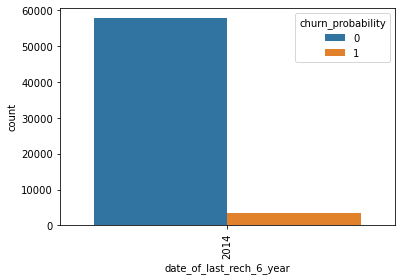

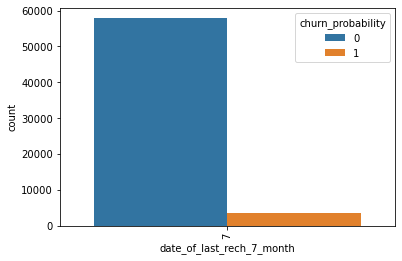

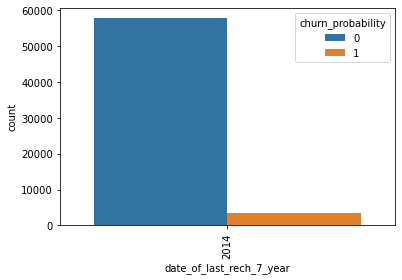

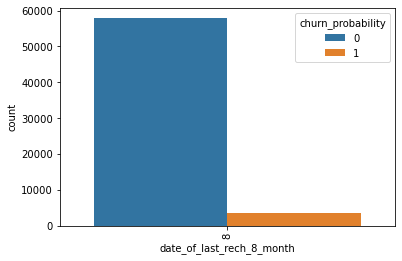

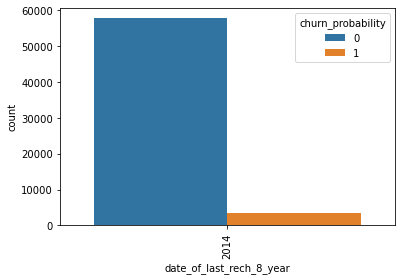

In [77]:
obj.categoricalColumnsAnalysis(categorical, segmented = True)

From the above analysis the churn probability is more for the current month than before. There are lesser data for churn probabilities = 1 than 0. Churn probabilities are higher for Service schemes with validity smaller than a month. Churn probabilities are also higher for 2g plans. 

In [78]:
Telecom_DF[categorical[0:10]]

,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6
52555,0,0,0,3,0,0,0,0,0,0
67382,0,0,0,0,0,0,0,0,0,0
56142,0,0,0,0,0,0,0,0,0,0
34206,0,0,0,0,0,0,0,0,0,0
31895,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
68802,0,0,0,0,1,1,7,6,7,0
40930,0,0,0,0,0,0,1,2,2,0
14966,0,0,0,0,1,2,8,5,3,0
36321,0,0,0,0,0,0,1,2,1,0


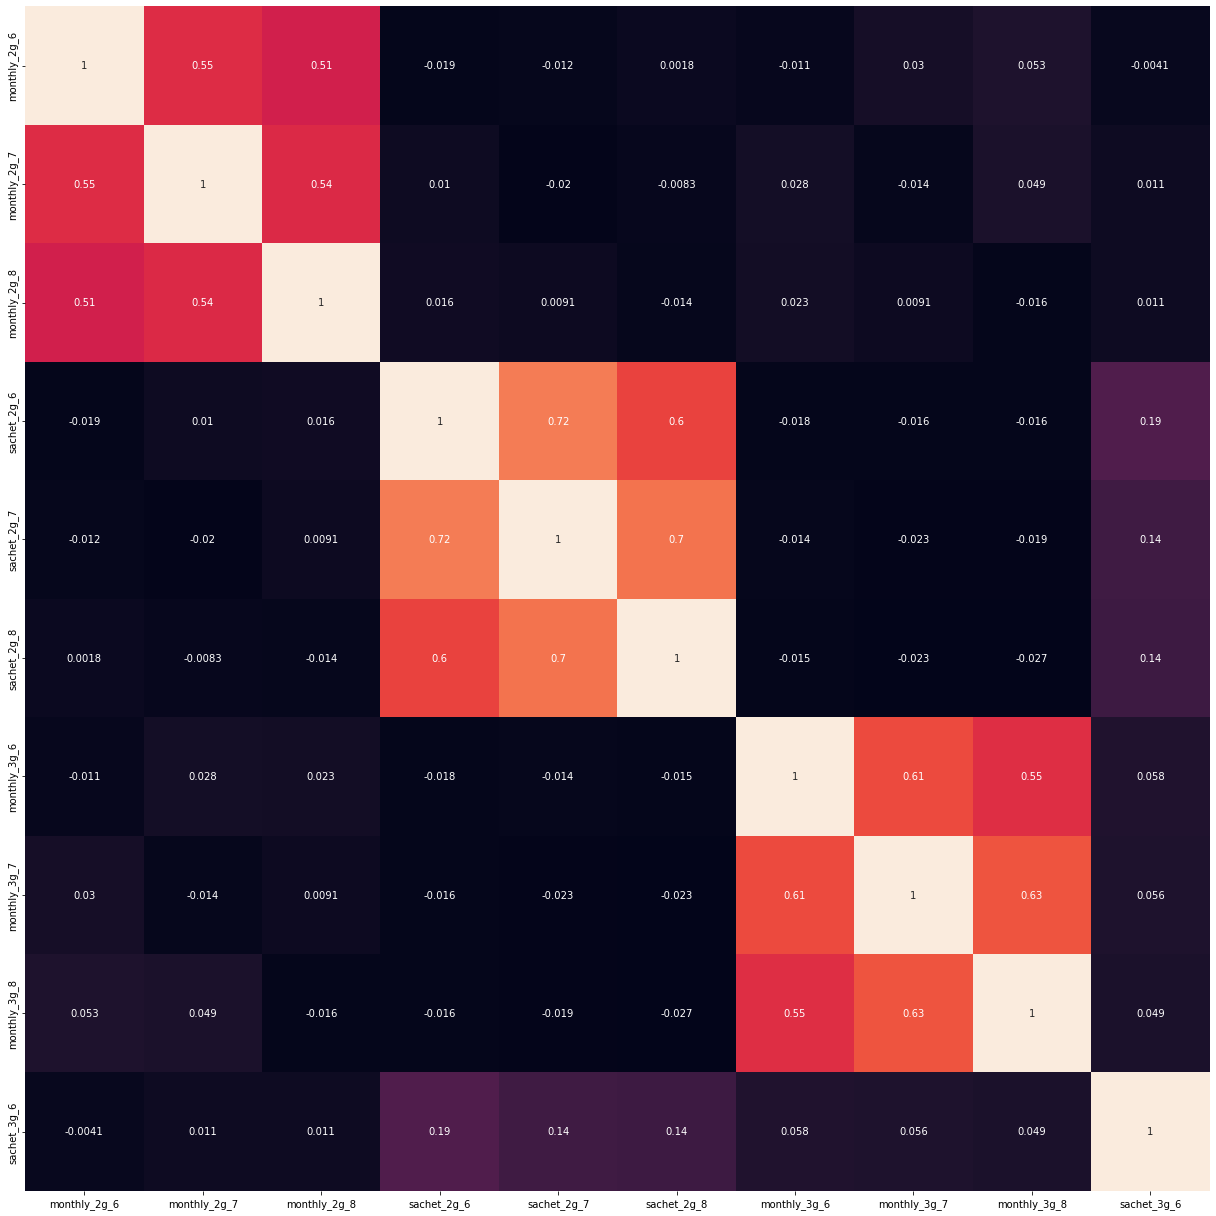

In [79]:
plt.figure(figsize=(17,17))
sb.heatmap(Telecom_DF[categorical[0:10]].corr(), annot = True, cbar = False)
plt.tight_layout()
plt.show()

Variables correlated with their own _6, _7 and _8. But removing it may lead to significant information loss. Also we will be using PCA so we won't use much of heatmaps as it is difficuilt to find correlation among many features. 

In [80]:
# Splitting the data into train and test
X = Telecom_DF.drop("churn_probability", axis = 1)
y = Telecom_DF.churn_probability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 43)

In [81]:
print("X Train data: ", X_train.shape) 
print("y Train data: ", y_train.shape)

X Train data:  (46045, 128)
y Train data:  (46045,)


We are not using VIF for Logistic Regression as VIF is giving not so good results compared to PCA.

In [82]:
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

In [83]:
pca = pca.named_steps['pca']
pca

PCA()

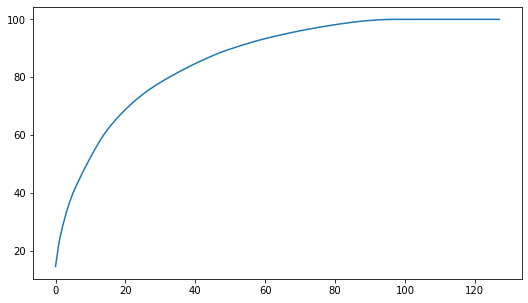

In [84]:
# plot feature variance - This will measure the spread between the numerical values in the variable. 
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
n_elements_Y = 100
n_elements_X = 175
normalizing_factor = 20
plt.figure(figsize=(n_elements_X/normalizing_factor,n_elements_Y/normalizing_factor)) # 175 elements on x-axis; 100 elements on y-axis; 20 is normalising factor
plt.plot(cumulative_variance)

In [85]:
# create pipeline
PCA_VARS = 80
steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline = Pipeline(steps)

In [86]:
# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)

0.7741774351178196

### Data Analysis for Test Data that was given 

In [87]:
TestDF = pd.read_csv('test (1).csv')

In [88]:
TestDF

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,99994,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,718.870,396.259,...,0,0,0,1.0,NaN,NaN,1255,3.71,105.64,61.48
29996,99995,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,218.327,324.070,...,0,0,0,NaN,0.0,NaN,2258,0.00,0.00,0.00
29997,99996,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,139.473,38.230,...,0,0,0,NaN,NaN,NaN,440,0.00,0.00,0.00
29998,99997,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1122.912,781.121,...,0,0,0,NaN,NaN,NaN,810,0.00,0.00,0.00


In [89]:
# We will get the day, month and year respectively.
# For this we will convert to datetime. 
TestDF["date_of_last_rech_6"] = pd.to_datetime(TestDF["date_of_last_rech_6"])
TestDF["date_of_last_rech_7"] = pd.to_datetime(TestDF["date_of_last_rech_7"])
TestDF["date_of_last_rech_8"] = pd.to_datetime(TestDF["date_of_last_rech_8"])

TestDF['date_of_last_rech_6_Day'] = TestDF['date_of_last_rech_6'].dt.day
TestDF['date_of_last_rech_6_month'] = TestDF['date_of_last_rech_6'].dt.month
TestDF['date_of_last_rech_6_year'] = TestDF['date_of_last_rech_6'].dt.year

TestDF['date_of_last_rech_7_Day'] = TestDF['date_of_last_rech_7'].dt.day
TestDF['date_of_last_rech_7_month'] = TestDF['date_of_last_rech_7'].dt.month
TestDF['date_of_last_rech_7_year'] = TestDF['date_of_last_rech_7'].dt.year

TestDF['date_of_last_rech_8_Day'] = TestDF['date_of_last_rech_8'].dt.day
TestDF['date_of_last_rech_8_month'] = TestDF['date_of_last_rech_8'].dt.month
TestDF['date_of_last_rech_8_year'] = TestDF['date_of_last_rech_8'].dt.year

In [90]:
# We will now drop the date colums. 
colsToRemove = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
TestDF = TestDF.drop(colsToRemove, axis = 1)

In [91]:
print(list(TestDF.columns))

['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_

In [92]:
TestDF

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,jun_vbc_3g,date_of_last_rech_6_Day,date_of_last_rech_6_month,date_of_last_rech_6_year,date_of_last_rech_7_Day,date_of_last_rech_7_month,date_of_last_rech_7_year,date_of_last_rech_8_Day,date_of_last_rech_8_month,date_of_last_rech_8_year
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0.00,21.0,6.0,2014.0,26.0,7.0,2014.0,24.0,8.0,2014.0
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0.00,19.0,6.0,2014.0,16.0,7.0,2014.0,24.0,8.0,2014.0
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,241.84,29.0,6.0,2014.0,27.0,7.0,2014.0,28.0,8.0,2014.0
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0.00,25.0,6.0,2014.0,30.0,7.0,2014.0,24.0,8.0,2014.0
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0.00,29.0,6.0,2014.0,29.0,7.0,2014.0,30.0,8.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,99994,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,718.870,396.259,...,61.48,27.0,6.0,2014.0,27.0,7.0,2014.0,29.0,8.0,2014.0
29996,99995,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,218.327,324.070,...,0.00,18.0,6.0,2014.0,24.0,7.0,2014.0,29.0,8.0,2014.0
29997,99996,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,139.473,38.230,...,0.00,22.0,6.0,2014.0,10.0,7.0,2014.0,30.0,8.0,2014.0
29998,99997,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1122.912,781.121,...,0.00,30.0,6.0,2014.0,18.0,7.0,2014.0,31.0,8.0,2014.0


In [93]:
# Equate negative values to 0 in the test data as we did for Train data. 
TestDF['arpu_8']=TestDF['arpu_8'].mask(TestDF['arpu_8'].lt(0),0)
TestDF['arpu_7']=TestDF['arpu_7'].mask(TestDF['arpu_7'].lt(0),0)
TestDF['arpu_6']=TestDF['arpu_6'].mask(TestDF['arpu_6'].lt(0),0)

In [94]:
obj = DataUnderstanding(TestDF)
UnwantedColumnsList = obj.RemoveUnwantedRowsCols.nullValueColumnAnalysis()
UnwantedColumnsList

There are  131  null column values with more than the given threshold.So we should be removing it.


,Null Count
loc_og_t2o_mou,316
std_og_t2o_mou,316
loc_ic_t2o_mou,316
last_date_of_month_7,202
last_date_of_month_8,367
...,...
date_of_last_rech_7_month,533
date_of_last_rech_7_year,533
date_of_last_rech_8_Day,1161
date_of_last_rech_8_month,1161


In [95]:
WantedDF = TestDF[['id','jul_vbc_3g', 'total_rech_amt_7', 'total_rech_amt_6', 'monthly_3g_8', 'total_og_mou_8', 'total_ic_mou_7', 'total_ic_mou_6', 'total_rech_num_8', 'monthly_3g_6', 'monthly_2g_7', 'arpu_7', 'vol_2g_mb_8', 'arpu_8', 'monthly_3g_7', 'max_rech_amt_8', 'aon', 'sachet_2g_7', 'total_rech_amt_8', 'jun_vbc_3g', 'vol_3g_mb_7', 'monthly_2g_8', 'sachet_2g_8', 'monthly_2g_6', 'aug_vbc_3g', 'sachet_3g_8', 'last_day_rch_amt_8', 'total_rech_num_6', 'max_rech_amt_7', 'vol_2g_mb_6', 'vol_3g_mb_6', 'vol_2g_mb_7', 'vol_3g_mb_8', 'last_day_rch_amt_6', 'sachet_3g_7', 'sachet_2g_6', 'total_og_mou_7', 'max_rech_amt_6', 'sachet_3g_6', 'total_ic_mou_8', 'arpu_6', 'total_og_mou_6', 'total_rech_num_7', 'last_day_rch_amt_7']]

In [96]:
UnwantedColumnsTest = list(UnwantedColumnsList.index)

In [97]:
# Let us drop the rows and store it in a temporary variable to make a prediction accordingly. 
Temp_Test_DF = TestDF[UnwantedColumnsTest].fillna(0)

In [98]:
Temp_Test_DF

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_7,last_date_of_month_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,...,fb_user_8,date_of_last_rech_6_Day,date_of_last_rech_6_month,date_of_last_rech_6_year,date_of_last_rech_7_Day,date_of_last_rech_7_month,date_of_last_rech_7_year,date_of_last_rech_8_Day,date_of_last_rech_8_month,date_of_last_rech_8_year
0,0.0,0.0,0.0,7/31/2014,8/31/2014,31.78,20.23,23.11,60.16,32.16,...,0.0,21.0,6.0,2014.0,26.0,7.0,2014.0,24.0,8.0,2014.0
1,0.0,0.0,0.0,7/31/2014,8/31/2014,75.51,41.21,19.84,474.34,621.84,...,0.0,19.0,6.0,2014.0,16.0,7.0,2014.0,24.0,8.0,2014.0
2,0.0,0.0,0.0,7/31/2014,8/31/2014,7.54,7.86,8.40,16.98,45.81,...,0.0,29.0,6.0,2014.0,27.0,7.0,2014.0,28.0,8.0,2014.0
3,0.0,0.0,0.0,7/31/2014,8/31/2014,5.31,2.16,0.00,40.04,205.01,...,0.0,25.0,6.0,2014.0,30.0,7.0,2014.0,24.0,8.0,2014.0
4,0.0,0.0,0.0,7/31/2014,8/31/2014,450.93,609.03,700.68,60.94,23.84,...,0.0,29.0,6.0,2014.0,29.0,7.0,2014.0,30.0,8.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.0,0.0,0.0,7/31/2014,8/31/2014,324.46,250.01,285.41,190.36,166.14,...,0.0,27.0,6.0,2014.0,27.0,7.0,2014.0,29.0,8.0,2014.0
29996,0.0,0.0,0.0,7/31/2014,8/31/2014,263.79,467.24,650.26,108.53,124.11,...,0.0,18.0,6.0,2014.0,24.0,7.0,2014.0,29.0,8.0,2014.0
29997,0.0,0.0,0.0,7/31/2014,8/31/2014,11.08,14.89,19.94,37.24,16.74,...,0.0,22.0,6.0,2014.0,10.0,7.0,2014.0,30.0,8.0,2014.0
29998,0.0,0.0,0.0,7/31/2014,8/31/2014,122.74,50.23,26.46,1854.09,1088.83,...,0.0,30.0,6.0,2014.0,18.0,7.0,2014.0,31.0,8.0,2014.0


In [99]:
Temp_Test_DF = Temp_Test_DF.join(WantedDF)

In [100]:
# Store in TestDF for later use.
TestDF = Temp_Test_DF

We will now do the predictions for Test data in that was split from the training set. 

In [101]:
def calculateSensitivitySpecificity(confusionMatrix):
    TP = confusionMatrix[0][0]
    FP = confusionMatrix[0][1]
    FN = confusionMatrix[1][0]
    TN = confusionMatrix[1][1]
    Precision = TP/(TP+FP) 
    print(ColorForPrint.BOLD, "Precision:", ColorForPrint.END)
    print(Precision)
    Recall = TP/(TP+FN)
    print(ColorForPrint.BOLD, "Recall:", ColorForPrint.END)
    print(Recall)
    Sensitivity = TP/(TP + FN)
    Specificity = TN/(TN + FP)
    return Sensitivity, Specificity

In [102]:
# predict the churn probabilities on test data
y_pred = pipeline.predict(X_test)

# create confusion matrix
confusionMatrix = confusion_matrix(y_test, y_pred)
print(ColorForPrint.BOLD, "Confusion Matrix:", ColorForPrint.END)
print(confusionMatrix)
Sensitivity, Specificity = calculateSensitivitySpecificity(confusionMatrix)
print(ColorForPrint.BOLD, "Sensitivity:", ColorForPrint.END)
print(Sensitivity)
print(ColorForPrint.BOLD, "Specificity:", ColorForPrint.END)
print(Specificity)

# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print(ColorForPrint.BOLD, "AUC:", ColorForPrint.END)
print(round(roc_auc_score(y_test, y_pred_prob),2))

 Confusion Matrix: 
[[11214  3272]
 [  147   716]]
 Precision: 
0.774126743062267
 Recall: 
0.9870609981515711
 Sensitivity: 
0.9870609981515711
 Specificity: 
0.17953861584754263
 AUC: 
0.87


The AUC for Logistic regression is 0.87 which is a pretty good score. Specifity has a low score here. But we will still have to see for other models as well.

In [103]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight={0:0.2, 1:0.8})

# create pipeline
steps = [("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'pca__n_components': [45,80], 'logistic__C': [0.1, 0.5, 1, 5, 10], 'logistic__penalty': ['l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model_improvised = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [104]:
# fit model
model_improvised.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.2,
                                                                         1: 0.8}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 5, 10],
                         'logistic__penalty': ['l2'],
                         'pca__n_components': [45, 80]},
             scoring='roc_auc', verbose=1)

In [105]:
# cross validation results
pd.DataFrame(model_improvised.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15.758062,6.322656,0.128444,0.015573,0.1,l2,45,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.850873,0.857324,0.862862,0.851111,0.852431,0.854920,0.004603,6
1,5.853807,0.110829,0.096893,0.020441,0.1,l2,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.862553,0.866866,0.874111,0.867519,0.862178,0.866645,0.004318,5
2,3.752294,0.362059,0.123520,0.015827,0.5,l2,45,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.850396,0.857208,0.863103,0.850190,0.852803,0.854740,0.004886,8
3,7.011512,0.645635,0.089888,0.025866,0.5,l2,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.862817,0.866899,0.874251,0.868073,0.861603,0.866729,0.004472,3
4,4.400873,0.835609,0.096778,0.022796,1,l2,45,"{'logistic__C': 1, 'logistic__penalty': 'l2', ...",0.850242,0.856759,0.862524,0.851746,0.852399,0.854734,0.004457,9
5,5.809775,0.137955,0.100845,0.010963,1,l2,80,"{'logistic__C': 1, 'logistic__penalty': 'l2', ...",0.862866,0.866982,0.874279,0.868054,0.861598,0.866756,0.004474,2
6,3.477294,0.037953,0.107166,0.014624,5,l2,45,"{'logistic__C': 5, 'logistic__penalty': 'l2', ...",0.849217,0.858254,0.862850,0.850383,0.853177,0.854776,0.005100,7
7,6.130832,0.603563,0.099818,0.010109,5,l2,80,"{'logistic__C': 5, 'logistic__penalty': 'l2', ...",0.862901,0.867120,0.874352,0.868276,0.861528,0.866835,0.004523,1
8,3.377057,0.128802,0.120356,0.028811,10,l2,45,"{'logistic__C': 10, 'logistic__penalty': 'l2',...",0.849500,0.857650,0.861229,0.851488,0.853416,0.854657,0.004250,10
9,5.795368,1.189789,0.103217,0.029545,10,l2,80,"{'logistic__C': 10, 'logistic__penalty': 'l2',...",0.862837,0.866932,0.874243,0.868112,0.861372,0.866699,0.004522,4


In [106]:
# print best hyperparameters
print("Best AUC: ", model_improvised.best_score_)
print("Best hyperparameters: ", model_improvised.best_params_)

Best AUC:  0.8668354656771735
Best hyperparameters:  {'logistic__C': 5, 'logistic__penalty': 'l2', 'pca__n_components': 80}


In [107]:
# predict churn on test data
y_pred = model_improvised.predict(X_test)

# create confusion matrix
confusionMatrix_improvised = confusion_matrix(y_test, y_pred)
print(ColorForPrint.BOLD, "Confusion Matrix:", ColorForPrint.END)
print(confusionMatrix_improvised)
Sensitivity, Specificity = calculateSensitivitySpecificity(confusionMatrix_improvised)
print(ColorForPrint.BOLD, "Sensitivity:", ColorForPrint.END)
print(Sensitivity)
print(ColorForPrint.BOLD, "Specificity:", ColorForPrint.END)
print(Specificity)

# check area under curve
y_pred_prob = model_improvised.predict_proba(X_test)[:, 1]
print(ColorForPrint.BOLD,"AUC:", ColorForPrint.END, round(roc_auc_score(y_test, y_pred_prob),4))

 Confusion Matrix: 
[[13910   576]
 [  488   375]]
 Precision: 
0.9602374706613281
 Recall: 
0.966106403667176
 Sensitivity: 
0.966106403667176
 Specificity: 
0.3943217665615142
 AUC:  0.8691


The confusion matrix gave better results for True positive compared to the previoius one. Specificity increased. 

#### Decision Tree

In [108]:
# fit the model with the training data
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [109]:
# predict the target on the train dataset
predict_train = model_decision_tree.predict(X_train)
predict_train

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [110]:
trainaccuracy = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', trainaccuracy)

accuracy_score on train dataset :  1.0


Check For VIF

In [111]:
X_TelecomProcessedVIFDF = pd.DataFrame()
X_TelecomProcessedVIFDF["Features"] = X_train.columns
  
# calculating VIF for each feature
X_TelecomProcessedVIFDF["Variance Inflation Factor"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
X_TelecomProcessedVIFDF

,Features,Variance Inflation Factor
0,arpu_6,18.036403
1,arpu_7,22.885035
2,arpu_8,22.032220
3,onnet_mou_6,11766.145922
4,onnet_mou_7,5236.655641
...,...,...
123,date_of_last_rech_7_month,0.000000
124,date_of_last_rech_7_year,0.000000
125,date_of_last_rech_8_Day,1.359917
126,date_of_last_rech_8_month,0.000000


In [112]:
X_TelecomProcessedVIFDF = X_TelecomProcessedVIFDF[(X_TelecomProcessedVIFDF["Variance Inflation Factor"] != math.inf) & (X_TelecomProcessedVIFDF["Variance Inflation Factor"] < 5)]
X_TelecomProcessedVIFDF.sort_values(by = ['Variance Inflation Factor'])

,Features,Variance Inflation Factor
127,date_of_last_rech_8_year,0.000000
124,date_of_last_rech_7_year,0.000000
123,date_of_last_rech_7_month,0.000000
121,date_of_last_rech_6_year,0.000000
120,date_of_last_rech_6_month,0.000000
126,date_of_last_rech_8_month,0.000000
115,aon,1.243162
125,date_of_last_rech_8_Day,1.359917
122,date_of_last_rech_7_Day,1.384555
119,date_of_last_rech_6_Day,1.411030


In [113]:
len(X_TelecomProcessedVIFDF)

45

In [114]:
vif_cols = list(X_TelecomProcessedVIFDF['Features'])

In [115]:
X_train_dt = X_train[vif_cols]

In [116]:
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(X_train_dt,y_train)

DecisionTreeClassifier()

In [117]:
# predict the target on the train dataset
predict_train = model_decision_tree.predict(X_train_dt)
predict_train

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [118]:
confusionMatrixDecisionTree = confusion_matrix(y_train, predict_train )
print(ColorForPrint.BOLD, "Confusion Matrix:", ColorForPrint.END)
print(confusionMatrixDecisionTree)

 Confusion Matrix: 
[[43328     0]
 [    0  2717]]


In [119]:
X_test_dt = X_test[vif_cols]

In [120]:
# predict the target on the test dataset
predict_test = model_decision_tree.predict(X_test_dt)
print('Target on test data\n\n',predict_test)

Target on test data

 [1 0 1 ... 0 0 0]


In [121]:
confusionMatrixDTImprovised = confusion_matrix(y_test, predict_test )
print(ColorForPrint.BOLD, "Confusion Matrix:", ColorForPrint.END)
print(confusionMatrixDTImprovised)

 Confusion Matrix: 
[[13751   735]
 [  574   289]]


In [122]:
# create confusion matrix
Sensitivity, Specificity = calculateSensitivitySpecificity(confusionMatrixDTImprovised)
print(ColorForPrint.BOLD, "Sensitivity:", ColorForPrint.END)
print(Sensitivity)
print(ColorForPrint.BOLD, "Specificity:", ColorForPrint.END)
print(Specificity)

# check area under curve
y_pred_prob = model_decision_tree.predict_proba(X_test_dt)[:, 1]
print(ColorForPrint.BOLD,"AUC:", ColorForPrint.END, round(roc_auc_score(y_test, y_pred_prob),4))

 Precision: 
0.9492613557917989
 Recall: 
0.9599301919720767
 Sensitivity: 
0.9599301919720767
 Specificity: 
0.2822265625
 AUC:  0.6421


AUC performed bad on test data because of overfitting nature of decision trees. 

### Random Forest

In [123]:
# random forest - the class weight is used to handle class imbalance - it adjusts the cost function. 
# This will give good score for specificity. 
forest = RandomForestClassifier(class_weight={0:0.2, 1: 0.8}, n_jobs = -1)

# hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model_rf = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [124]:
# fitting the model
model_rf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 0.2, 1: 0.8},
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 0.4]},
             scoring='roc_auc', verbose=1)

In [125]:
# print best hyperparameters
print("Best AUC: ", model_rf.best_score_)
print("Best hyperparameters: ", model_rf.best_params_)

Best AUC:  0.922566265406191
Best hyperparameters:  {'criterion': 'entropy', 'max_features': 0.4}


In [126]:
# predict churn on test data
y_pred = model_rf.predict(X_test)

# create confusion matrix
confusionMatrixRF = confusion_matrix(y_test, y_pred)
print(ColorForPrint.BOLD, "Confusion Matrix:", ColorForPrint.END)
print(confusionMatrixRF)

# check sensitivity and specificity
Sensitivity, Specificity = calculateSensitivitySpecificity(confusionMatrixRF)
print(ColorForPrint.BOLD, "Sensitivity:", ColorForPrint.END)
print(Sensitivity)
print(ColorForPrint.BOLD, "Specificity:", ColorForPrint.END)
print(Specificity)

# check area under curve
y_pred_prob = model_rf.predict_proba(X_test)[:, 1]
print(ColorForPrint.BOLD,"AUC:", ColorForPrint.END, round(roc_auc_score(y_test, y_pred_prob),4))

 Confusion Matrix: 
[[14316   170]
 [  546   317]]
 Precision: 
0.9882645312715725
 Recall: 
0.9632620104965685
 Sensitivity: 
0.9632620104965685
 Specificity: 
0.6509240246406571
 AUC:  0.9247


From the above 3 models, Random Forest gave the best results with AUC. 

## Predict from the test set given

In [127]:
# We will now replace the data. 
X_test = TestDF[list(X_train.columns)]

In [128]:
# predict churn on test data
y_predForTest = model_rf.predict(X_test)

In [129]:
y_predForTest

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [130]:
# Check for null values in the dataframe. 
(X_test < 0).sum().any()

False

In [131]:
churnProbabilitySeries = pd.Series(y_predForTest, name = "churn_probability")
ChurnProbabilityDF = pd.concat([TestDF.id, churnProbabilitySeries], axis=1)

In [132]:
ChurnProbabilityDF

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0
...,...,...
29995,99994,0
29996,99995,0
29997,99996,0
29998,99997,0


In [133]:
ChurnProbabilityDF = ChurnProbabilityDF.dropna()
ChurnProbabilityDF["churn_probability"] = ChurnProbabilityDF["churn_probability"].astype("int64")

In [134]:
ChurnProbabilityDF

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0
...,...,...
29995,99994,0
29996,99995,0
29997,99996,0
29998,99997,0


In [135]:
ChurnProbabilityDF.to_csv("solution (1).csv", index = False)

<b>The most impacting variables are:</b><br>
'date_of_last_rech_8_year',
 'date_of_last_rech_6_month',
 'date_of_last_rech_6_year',
 'date_of_last_rech_7_month',
 'date_of_last_rech_8_month',
 'date_of_last_rech_7_year',
 'aon',
 'date_of_last_rech_8_Day',
 'date_of_last_rech_7_Day',
 'date_of_last_rech_6_Day',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_8',
 'og_others_6',
 'last_day_rch_amt_6',
 'sachet_3g_8',
 'sachet_3g_6',
 'last_day_rch_amt_7',
 'loc_og_t2c_mou_7',
 'roam_ic_mou_6',
 'vol_2g_mb_8',
 'monthly_2g_8',
 'monthly_2g_6',
 'last_day_rch_amt_8',
 'vol_2g_mb_6',
 'monthly_2g_7',
 'sachet_3g_7',
 'sachet_2g_8',
 'vol_2g_mb_7',
 'sachet_2g_6',
 'roam_ic_mou_8',
 'roam_ic_mou_7',
 'monthly_3g_6',
 'monthly_3g_8',
 'sachet_2g_7',
 'jun_vbc_3g',
 'monthly_3g_7',
 'aug_vbc_3g',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'jul_vbc_3g',
 'total_rech_num_6',
 'total_rech_num_8',
 'vol_3g_mb_6',
 'vol_3g_mb_8'

date_of_last_rech is the most impacting variable. aon is also an important variable. loc_og_t2c_mou_6 also gave significant importance. 

# Result Analysis

The operator should look into Age on network. Date last recharge is also an impacting variable for churn. Local calls within same telecom circle is also an impacting variable for churn. The operator should look into the last date recharge amount as well. Roaming incoming calls are also impacting the current customer. If the roaming charges are lower then churn is lesser. Also 2G is contributing to a higher churn as people are moving towards 3G. 